<a href="https://colab.research.google.com/github/fernando65535/Rodamientos/blob/main/Autoencoder_conv_FORMA_ONDA_y%20regresion%20de%20defectos_de_vibraciones.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

En este cuaderno se emplea un autoencoder directamente sobre la forma de onda con el fin de caracterizar con un vector de reducidas dimensiones y poder clasificar en base a este.


El vector "resumen" o bottleneck, debe ser capaz de reconstruir la forma de onda por lo que no hay mucha perdida de informacion.
Al aplicar la clasificación sobre este vector debería ser mas facil clasificar sin entrenar especificamente todo el modelo?

El proposito es distinguir fallos de montaje. Ajuste/juego, excentricidad de carga, fallo de lubricación, desequilibrio, desalineación ejes, etc. 

Tambien puede ser posible conocer el estado general del rodamiento.

El proceso a seguir:

1 Preparar datos.
Generar datos con fallos mediante sus armonicos caracteristicos
Mezclar con forma de onda de rodamiento en buen estado

2 Definir modelo con capas convolucionales reduciendo la dimension hasta un vector con dimensiones reducidas. Aplicar capas de convolucion inversa hasta generar la salida que imita la entrada reconstruida. El error debido a la reconstruccion sera la diferencia entre entrada y salida.



In [ ]:
#  https://pytorch.org/audio/stable/tutorials/audio_feature_extractions_tutorial.html#sphx-glr-tutorials-audio-feature-extractions-tutorial-py

In [ ]:
# datos de rodamientos https://engineering.case.edu/bearingdatacenter/12k-drive-end-bearing-fault-data

In [ ]:
#  https://info.endaq.com/hubfs/Plots/enDAQ-Vibration-Monitoring-Metrics-Case-Western-Bearing-Data_2.html

Table of Contents

    1  Introduction
    2  Data Source
    3  Plot Time Series Data
    4  Analysis in the Time Domain
        4.1  Easy Calculations of Peak, RMS and Crest Factor
            4.1.1  Calculate for Pure Sine Wave
        4.2  Integration to Velocity & Displacement
            4.2.1  First Compare Simple Sine Wave
            4.2.2  Calculate for Bearing Data
        4.3  Plot Integrated Velocity & Displacement
        4.4  Calculating RMS of Velocity and Displacement
    5  Analysis in the Frequency Domain
        5.1  FFT Function
        5.2  Compare FFT and PSD Results for Simple Sine Wave
        5.3  Compare FFT and PSD of Bearing Data
        5.4  FFT of Bearing Data
        5.5  Calculate PSD
            5.5.1  Peak from PSD
        5.6  Show How PSD Relates to RMS
        5.7  Calculate Velocity & Displacement from PSD
            5.7.1  PSD
            5.7.2  RMS from PSD
        5.8  Build Octave Spaced PSD
            5.8.1  Build Frequency Ranges
            5.8.2  Compare PSD of Linear and Log Spaced Bins
            5.8.3  Plot Cumulative RMS of Linear & Log Spaced PSDs
        5.9  Find RMS within Arbitrary Range
        5.10  Calculate Pseudo Velocity Shock Spectrum & Peak
    6  Compare Stats
        6.1  Table
        6.2  Plot Each Variable with a Drop Down
        6.3  Plot All Stats in One Dashboard
    7  Appendix
        7.1  Installation
            7.1.1  Modules
        7.2  Ploting in Jupyter
            7.2.1  Matplotlib
            7.2.2  Plotly (My Favorite)
                7.2.2.1  Save Plot to Chart Studio
                7.2.2.2  Save Plot as HTML and PNG
        7.3  Manipulating .MAT Files from Case Western into Pandas CSV

Introduction

The first section references where we got this data, and the second shows how to manipulate the source data into something Python likes better. This dataset was then loaded online for public acces. So you can skip these sections and jump straight to plotting the time series data (which will reload the now "cleaned" data).
Data Source

Data was downloaded from the Case Western Reserve Bearing Data Center where they did some seeded fault testing and shared the data. This data can be downloaded here. An overview of the procedure is here.

For simplicity we will look at 4 data files:

    Normal
    Fan End Fault, Inner Race
        Fault_007
        Fault_014
        Fault_007

All of these were when the motor was running at approximately 1772 RPM. The numbers in the fault file names signify the fault diameter in thousands of an inch. For example Fault_014 is a fan end bearing fault in the inner race measuring 0.014" in diameter.

In the appendix I show you how to pull out the data of interest from the source .MAT files. But I've uploaded the processed data into a CSV file which can be loaded directly from online. So we can skip those earlier steps (but they've been included for reference).


In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np

In [2]:
import librosa

In [3]:
import pandas as pd
df = pd.read_csv("https://info.endaq.com/hubfs/Plots/bearing_data.csv")
df = df.set_index('Time')
fs = len(df)/(df.index[-1]-df.index[0])    # Frecuencia de muestreo
print(fs)
df

12000.0


Fault_021  Fault_014  Fault_007    Normal
Time                                                
0.000000   -0.105351  -0.074395   0.053116  0.046104
0.000083    0.132888   0.056365   0.116628 -0.037134
0.000167   -0.056535   0.201257   0.083654 -0.089496
0.000250   -0.193178  -0.024528  -0.026477 -0.084906
0.000333    0.064879  -0.072284   0.045319 -0.038594
...              ...        ...        ...       ...
9.999667    0.095754   0.145055  -0.098923  0.064254
9.999750   -0.123083   0.092263  -0.067573  0.070721
9.999833   -0.036508  -0.168120   0.005685  0.103265
9.999917    0.097006  -0.035898   0.093400  0.124335
10.000000  -0.008762   0.165846   0.130923  0.114947

[120000 rows x 4 columns]

In [4]:
import scipy.io

In [5]:
# Clone the entire repo.
!git clone https://github.com/fernando65535/Rodamientos.git

Cloning into 'Rodamientos'...
remote: Enumerating objects: 16, done.
remote: Counting objects: 100% (16/16), done.
remote: Compressing objects: 100% (14/14), done.
remote: Total 16 (delta 3), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (16/16), done.


In [ ]:
#from google.colab import files
#files.upload() 

In [6]:
def load_mat(name,var):
    dic = scipy.io.loadmat("/content/Rodamientos/"+name+".mat")
    con_list = [[element for element in upperElement] for upperElement in dic[var]]
    df = pd.DataFrame(con_list)
    return df

In [ ]:
#scipy.io.loadmat("/content/100.mat")

In [7]:
t_normal1d = torch.tensor(load_mat('97','X097_DE_time').values,    dtype=torch.float)
t_normal2d = torch.tensor(load_mat('98','X098_DE_time').values,    dtype=torch.float)
t_normal3d = torch.tensor(load_mat('99','X099_DE_time').values,    dtype=torch.float)
t_normal4d = torch.tensor(load_mat('100','X100_DE_time').values,    dtype=torch.float)

In [8]:
t_normal1f = torch.tensor(load_mat('97','X097_DE_time').values,    dtype=torch.float)
t_normal2f = torch.tensor(load_mat('98','X098_DE_time').values,    dtype=torch.float)
t_normal3f = torch.tensor(load_mat('99','X099_DE_time').values,    dtype=torch.float)
t_normal4f = torch.tensor(load_mat('100','X100_DE_time').values,    dtype=torch.float)

In [9]:
print(t_normal1d.shape, " ", t_normal2d.shape, " ",t_normal3d.shape, " ",t_normal4d.shape, " ",t_normal1f.shape, " ", t_normal2f.shape, " ",t_normal3f.shape, " ",t_normal4f.shape) 

torch.Size([243938, 1])   torch.Size([483903, 1])   torch.Size([485063, 1])   torch.Size([485643, 1])   torch.Size([243938, 1])   torch.Size([483903, 1])   torch.Size([485063, 1])   torch.Size([485643, 1])



Plot Time Series Data

First let's plot the full dataset but render it as a SVG because it is so big.


In [ ]:
"""
pip install -U kaleido
import plotly.express as px
fig = px.line(df,
             labels={
                     "Time": "Time (s)",
                     "value": "Acceleration (g)",
                     "variable": "Data Set"
                 },
             title="Comparison of Bearing Acceleration Data")
fig.write_image("/content/-time-series.svg")
fig.show(renderer='svg',width=900, height=450)
"""

'\npip install -U kaleido\nimport plotly.express as px\nfig = px.line(df,\n             labels={\n                     "Time": "Time (s)",\n                     "value": "Acceleration (g)",\n                     "variable": "Data Set"\n                 },\n             title="Comparison of Bearing Acceleration Data")\nfig.write_image("/content/-time-series.svg")\nfig.show(renderer=\'svg\',width=900, height=450)\n'

Now let's get the full benefit of Plotly and render a the middle 1 second of the file as an interactive element. We'll also subtract 4.5 seconds from the time domain data so that these middle plots start at 0 and look good.

In [ ]:
"""
plot_start = 3.5
plot_end = 4.001

fig = px.line(df.loc[plot_start:plot_end],
             labels={
                     "Time": "Time (s)",
                     "value": "Acceleration (g)",
                     "variable": "Data Set"
                 },
             title="Interactive Comparison of Bearing Acceleration Data")
fig.write_html("/content/untitled",full_html=False,include_plotlyjs='cdn')
fig.show()
"""

'\nplot_start = 3.5\nplot_end = 4.001\n\nfig = px.line(df.loc[plot_start:plot_end],\n             labels={\n                     "Time": "Time (s)",\n                     "value": "Acceleration (g)",\n                     "variable": "Data Set"\n                 },\n             title="Interactive Comparison of Bearing Acceleration Data")\nfig.write_html("/content/untitled",full_html=False,include_plotlyjs=\'cdn\')\nfig.show()\n'

Conversion de datos a tensor 

Fault_021 	Fault_014 	Fault_007 	Normal

In [10]:
import torchaudio.transforms as T

In [ ]:
#x,y=x.type(torch.DoubleTensor),y.type(torch.DoubleTensor)

In [11]:
t_normal =    torch.tensor(df['Normal'].values,    dtype=torch.float)
t_fault_007 = torch.tensor(df['Fault_007'].values, dtype=torch.float)
t_fault_014 = torch.tensor(df['Fault_014'].values, dtype=torch.float)
t_fault_021 = torch.tensor(df['Fault_021'].values, dtype=torch.float)

10 segundos

frec muestreo 6000 Hz

frec rotacion 60 Hz?



Los rodamientos tienen una velocidad de rotacion de:
1772 RPM  =  1772 / 60 = 29,533 Hz


A continuacion se generan datos sinteticos:


In [12]:
CL = 120000
N_principal=1772 #revoluciones por minuto
Frec_principal=N_principal/60
CN = 1
Tiempo_total=10
Cx = np.empty((CN,CL), np.float32)
FC= N_principal
CT = CL/Tiempo_total*60/N_principal

Cx[:] = (np.array(range(CL)) + np.random.randint(-4*CT,4*CT,CN).reshape(CN,1))*3.141592*2
t_test0 = (((np.sin(Cx/1.0/CT)+np.sin(Cx*2/1.0/CT)+np.sin(Cx*3/1.0/CT)+np.sin(Cx*4/1.0/CT)+np.sin(Cx*5/1.0/CT)+np.sin(Cx*6/1.0/CT)+np.sin(Cx*7/1.0/CT)))/10).astype(np.float32)
#t_test0 = (np.sin(Cx/1.0/CT)+np.sin(Cx*2/1.0/CT)+np.sin(Cx*4/1.0/CT)+np.sin(Cx*8/1.0/CT)+np.sin(Cx*16/1.0/CT)+np.sin(Cx*32/1.0/CT)+np.sin(Cx*64/1.0/CT)).astype(np.float32)
t_test = torch.tensor(t_test0, dtype=torch.float).reshape(t_test0.shape[1])

In [13]:
t_test.shape

torch.Size([120000])

In [ ]:
"""def genera_vibracion(frec_muestreo, frec_princ, list_armon, ruido):
    
    vibracion=ruido
    N_muestras=ruido.shape[0]       #
    L_=ruido.shape[1]               # muestras ruido
    
    
    CL = vibracion.shape[1]         #120000                     NPuntos
    #frec_princ                      #revoluciones por minuto
    CN = vibracion.shape[0]         #numero de formas de onda   NOndas             
    
    
    
    CT = 1/frec_muestreo            #CT = CL/Tiempo_total*60/frec_princ

    
    #onda = torch.zeros(frec_muestreo//2)+ruido

    #Cx = np.empty((CN,CL), np.float32)
    Cx[:] = (np.array(range(CL)))#.reshape(CN,CL)

    for (_frec_relativa, _intensidad, _fase) in list_armon:
        vibracion = vibracion + (np.sin(Cx*frec_princ*_frec_relativa/frec_muestreo+_fase)*_intensidad).astype(np.float32)
        print("_frec_relativa ",_frec_relativa)
        print("_intensidad ",_intensidad)

    vibracion = torch.tensor(vibracion, dtype=torch.float)#.reshape(vibracion.shape[1])
    return vibracion
    """

'def genera_vibracion(frec_muestreo, frec_princ, list_armon, ruido):\n    \n    vibracion=ruido\n    N_muestras=ruido.shape[0]       #\n    L_=ruido.shape[1]               # muestras ruido\n    \n    \n    CL = vibracion.shape[1]         #120000                     NPuntos\n    #frec_princ                      #revoluciones por minuto\n    CN = vibracion.shape[0]         #numero de formas de onda   NOndas             \n    \n    \n    \n    CT = 1/frec_muestreo            #CT = CL/Tiempo_total*60/frec_princ\n\n    \n    #onda = torch.zeros(frec_muestreo//2)+ruido\n\n    #Cx = np.empty((CN,CL), np.float32)\n    Cx[:] = (np.array(range(CL)))#.reshape(CN,CL)\n\n    for (_frec_relativa, _intensidad, _fase) in list_armon:\n        vibracion = vibracion + (np.sin(Cx*frec_princ*_frec_relativa/frec_muestreo+_fase)*_intensidad).astype(np.float32)\n        print("_frec_relativa ",_frec_relativa)\n        print("_intensidad ",_intensidad)\n\n    vibracion = torch.tensor(vibracion, dtype=torch.flo

In [14]:
t_normal.shape[0]

120000

In [15]:
def genera_vibracion(frec_muestreo, frec_princ, list_armon, ruido):
    
    vibracion=ruido
    N_muestras=ruido.shape[0]       #
    
    
    
    #CL = vibracion.shape[0]         #120000                     NPuntos
    #frec_princ                      #revoluciones por minuto
    
    
    CT = 1/frec_muestreo            #CT = CL/Tiempo_total*60/frec_princ

    
    #onda = torch.zeros(frec_muestreo//2)+ruido

    #Cx = np.empty((CN,CL), np.float32)
    Cx[:] = (np.array(range(CL)))#.reshape(CN,CL)

    for (_frec_relativa, _intensidad, _fase) in list_armon:
        vibracion = vibracion + (np.sin(Cx*frec_princ*_frec_relativa/frec_muestreo+_fase)*_intensidad).astype(np.float32)
        print("_frec_relativa ",_frec_relativa)
        print("_intensidad ",_intensidad)

    vibracion = vibracion.clone().detach().reshape(1,N_muestras)
    return vibracion

In [16]:
L_arm1=[[1,.01,0],[2,0.02,0]]                       #_frec_relativa, _intensidad, _fase
L_arm2=[[4,.01,0],[6,0.02,0]] 
L_arm3=[[8,.01,0],[10,0.02,0]] 

L_arm=np.concatenate((L_arm1, L_arm2, L_arm3),axis=0)

L_arm

array([[ 1.  ,  0.01,  0.  ],
       [ 2.  ,  0.02,  0.  ],
       [ 4.  ,  0.01,  0.  ],
       [ 6.  ,  0.02,  0.  ],
       [ 8.  ,  0.01,  0.  ],
       [10.  ,  0.02,  0.  ]])

In [17]:
t_sint1 = genera_vibracion(frec_muestreo=12000, frec_princ=Frec_principal, list_armon=L_arm, ruido=t_normal)  # Se realiza la superposicion de armonicos y ruido de rodamiento en buen estado

_frec_relativa  1.0
_intensidad  0.01
_frec_relativa  2.0
_intensidad  0.02
_frec_relativa  4.0
_intensidad  0.01
_frec_relativa  6.0
_intensidad  0.02
_frec_relativa  8.0
_intensidad  0.01
_frec_relativa  10.0
_intensidad  0.02


In [18]:
t_sint2 = genera_vibracion(frec_muestreo=12000, frec_princ=Frec_principal, list_armon=L_arm1, ruido=t_normal)  # Se realiza la superposicion de armonicos y ruido de rodamiento en buen estado

_frec_relativa  1
_intensidad  0.01
_frec_relativa  2
_intensidad  0.02


In [19]:
t_sint3 = genera_vibracion(frec_muestreo=12000, frec_princ=Frec_principal, list_armon=L_arm2, ruido=t_normal)  # Se realiza la superposicion de armonicos y ruido de rodamiento en buen estado

_frec_relativa  4
_intensidad  0.01
_frec_relativa  6
_intensidad  0.02


In [20]:
t_sint4 = genera_vibracion(frec_muestreo=12000, frec_princ=Frec_principal, list_armon=L_arm3, ruido=t_normal)  # Se realiza la superposicion de armonicos y ruido de rodamiento en buen estado

_frec_relativa  8
_intensidad  0.01
_frec_relativa  10
_intensidad  0.02


In [21]:
t_sint5 = genera_vibracion(frec_muestreo=12000, frec_princ=Frec_principal, list_armon=L_arm, ruido=t_fault_007)  # Se realiza la superposicion de armonicos y ruido de rodamiento en buen estado

_frec_relativa  1.0
_intensidad  0.01
_frec_relativa  2.0
_intensidad  0.02
_frec_relativa  4.0
_intensidad  0.01
_frec_relativa  6.0
_intensidad  0.02
_frec_relativa  8.0
_intensidad  0.01
_frec_relativa  10.0
_intensidad  0.02


In [22]:
t_sint6 = genera_vibracion(frec_muestreo=12000, frec_princ=Frec_principal, list_armon=L_arm3, ruido=t_fault_014)  # Se realiza la superposicion de armonicos y ruido de rodamiento en buen estado

_frec_relativa  8
_intensidad  0.01
_frec_relativa  10
_intensidad  0.02


In [23]:
t_sint7 = genera_vibracion(frec_muestreo=12000, frec_princ=Frec_principal, list_armon=L_arm2, ruido=t_fault_021)  # Se realiza la superposicion de armonicos y ruido de rodamiento en buen estado

_frec_relativa  4
_intensidad  0.01
_frec_relativa  6
_intensidad  0.02


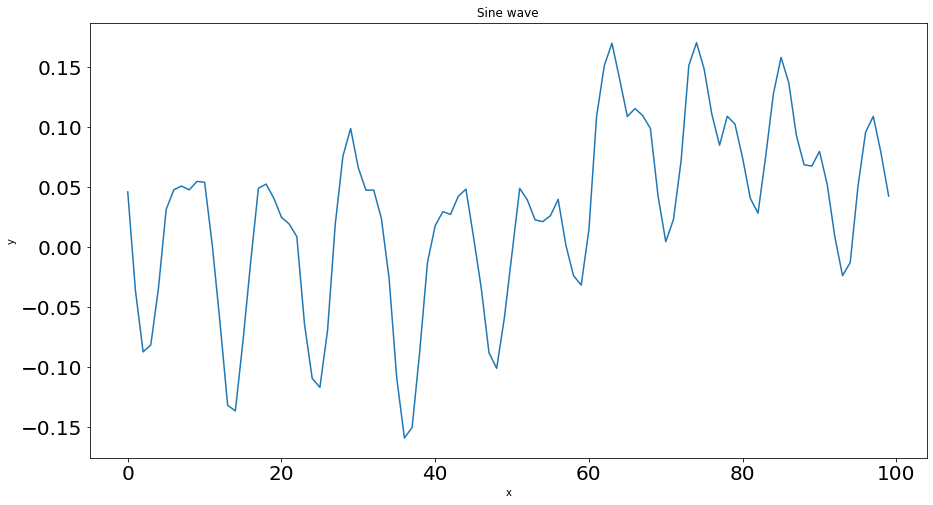

In [24]:
plt.figure(figsize=(15,8))
plt.title("Sine wave")
plt.xlabel("x")
plt.ylabel("y")
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.plot(t_sint1[0,:100])#plt.plot(Cx[0],t_test0[0])
plt.show()

In [ ]:
CT

614.3344709897611

In [ ]:
t_test.shape

torch.Size([120000])

In [25]:
import matplotlib.pyplot as plt

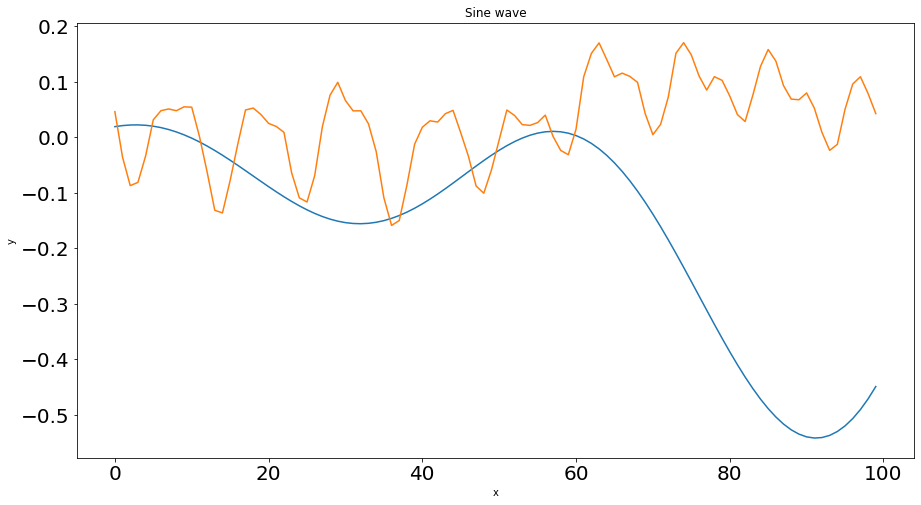

In [26]:

plt.figure(figsize=(15,8))
plt.title("Sine wave")
plt.xlabel("x")
plt.ylabel("y")
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.plot(Cx[0,:100],t_test0[0,:100])#plt.plot(Cx[0],t_test0[0])
plt.plot(Cx[0,:100],t_sint1[0,:100])#plt.plot(Cx[0],t_test0[0])
plt.show()

In [ ]:
#plt.plot(np.arange(espec_normal.shape[0]),espec_test[:,100].log())#plt.plot(np.arange(espec_normal.shape[1]),espec_normal[0])
#plt.show()

In [ ]:
t_normal.shape[0]

120000

In [29]:
t_normal.shape

torch.Size([1, 120000])

In [27]:
t_normal=torch.reshape(t_normal,(1,t_normal.shape[0]))
t_fault_007=torch.reshape(t_fault_007,(1,t_fault_007.shape[0]))
t_fault_014=torch.reshape(t_fault_014,(1,t_fault_014.shape[0]))
t_fault_021=torch.reshape(t_fault_021,(1,t_fault_021.shape[0]))
t_test=torch.reshape(t_test,(1,t_test.shape[0]))





In [31]:
t_normal1d[:120000].shape

torch.Size([120000, 1])

In [32]:
t_normal.shape[0]

1

In [33]:
t_normal1d=torch.reshape(t_normal1d[:120000],(1,t_normal.shape[1]))
t_normal2d=torch.reshape(t_normal2d[:120000],(1,t_normal.shape[1]))
t_normal3d=torch.reshape(t_normal3d[:120000],(1,t_normal.shape[1]))
t_normal4d=torch.reshape(t_normal4d[:120000],(1,t_normal.shape[1]))
t_normal1f=torch.reshape(t_normal1f[:120000],(1,t_normal.shape[1]))
t_normal2f=torch.reshape(t_normal2f[:120000],(1,t_normal.shape[1]))
t_normal3f=torch.reshape(t_normal3f[:120000],(1,t_normal.shape[1]))
t_normal4f=torch.reshape(t_normal4f[:120000],(1,t_normal.shape[1]))

In [34]:
datos0=torch.cat((t_normal,t_normal1d,t_normal2d,t_normal3d,t_normal4d, t_normal1f, t_normal2f, t_normal3f, t_normal4f),dim=0)

In [ ]:
#datos4=torch.cat((espec_normal,espec_fault_007,espec_fault_014,espec_fault_021,espec_test),dim=1)
datos0=torch.cat((t_normal,t_fault_007,t_fault_014,t_fault_021,t_test, t_sint1, t_sint2, t_sint3, t_sint4, t_sint5, t_sint6, t_sint7),dim=0)

In [35]:
print(datos0.shape)

torch.Size([9, 120000])


In [ ]:
#La estructuara de lo 

In [36]:
print(datos0.shape)
#print(datos4.shape)
print(datos0)

torch.Size([9, 120000])
tensor([[ 0.0461, -0.0371, -0.0895,  ...,  0.1033,  0.1243,  0.1149],
        [ 0.0532,  0.0887,  0.0997,  ..., -0.0665, -0.0367,  0.0405],
        [ 0.0461, -0.0371, -0.0895,  ...,  0.1033,  0.1243,  0.1149],
        ...,
        [ 0.0461, -0.0371, -0.0895,  ...,  0.1033,  0.1243,  0.1149],
        [ 0.0643,  0.0630, -0.0044,  ..., -0.1362, -0.1091, -0.0720],
        [ 0.0146,  0.0544,  0.1076,  ...,  0.0507,  0.0630,  0.0444]])


In [ ]:
#datos1=torch.transpose(datos0, 0, 1)
#print(datos1.shape)

In [37]:
datos=datos0#.reshape(datos0.shape[0],1,datos0.shape[1])


In [ ]:
print(datos.shape)

torch.Size([9, 120000])


In [ ]:
# Debemos normalizar datos 

In [ ]:
#Mejor con transforms normalize empleando valores fijados

In [39]:
media=datos.mean()
varianza=datos.std()

In [40]:
datos=(datos-media)/varianza

Dataloader 

En cada vector de datos se suministra una columna, es decir un espectro fft, aleatoriamente. Recibe de los distintos ejemplos indistintamente.

El modelo autoencoder reduce el numero de dimensiones comprimiendolo (bottleneck) y lo reconstruye. Se calcula el error (loss) y se corrigen pesos(backpropagation).

Una vez entrenado nos quedamos con la primera mitad del modelo hasta el cuello de botella (bottleneck) y añadimos unas capas densas y finalmente softmax para clasificar

DATALOADER

En estos datos la longitud L es 120000 y hay N formas de onda.

Cada iteracion debe suministrar una onda con longitud 1025 puntos (por ejemplo)

Debemos estructurar los datos de forma que para cada index devuelva una muestra de 1025, sin mezclar formas de onda.

Cada iteracion puede dar un salto de 100 de forma que

120.000-1.025=118.975

118.975//100 = 1.189 posibles muestras

Si ahora tenemos 7 formas de onda:

1.189 * 7 = 8.323 muestras para entrenar el sistema

Para extraer un dato en funcion de index:

L=x.shape[1]

Lm=1025

nm=(L-Lm)//100    numero de muestras por cada forma de onda

Fo=x.shape[0]    formas de onda

Nmuestras = Fo*nm

Para recuperar una muestra en funcion de index:

x[a,b:c]


a,d=divmod(index,nm)

b=d*100

c=b+1025

In [ ]:
datos.shape

torch.Size([9, 120000])

In [41]:
from torch.utils.data import Dataset, DataLoader

In [42]:
class Muestra_ONDA_Dataset(Dataset):
    def __init__(self,datos):
        #
        
        self.x=datos
        
        self.nm=(datos.shape[1]-1025)//110
        self.n_m_total=datos.shape[0]*self.nm


    def __getitem__(self,index):
        #extraer un elemento indexado
        #dataset[0]
        
        a=index//self.nm
        d=index%self.nm
        b=d*110
        c=b+1025
        return torch.reshape(self.x[a,b:c],(1,1025))#self.x[a,b:c]#
    
    def __len__(self):
        #longitud de datos
        #len(dataset)
        return self.n_m_total



In [43]:
dataset=Muestra_ONDA_Dataset(datos)

In [44]:
dataloader = DataLoader(dataset=dataset, batch_size=150, shuffle=True, num_workers=2)
dataiter = iter(dataloader)

data = dataiter.next()
print(data.shape)
#print(data)

torch.Size([150, 1, 1025])


In [ ]:
#import torch.fft

In [ ]:
"""n_fft = 1024*2               #1024
win_length = None          #None
hop_length = 512           #512



espec_spectrogram = T.Spectrogram(
    n_fft=n_fft,
    win_length=win_length,
    hop_length=hop_length,
    pad_mode="reflect",
    power=2.0,
    onesided=True
)
"""

DEFINICION DE MODELO

In [ ]:
stop

NameError: ignored

In [45]:
class Autoencoder(nn.Module):
    def __init__(self):
        super().__init__()
        # N, 1, 1025 
        #class torch.nn.Conv1d(in_channels, out_channels, kernel_size, stride=1, padding=0, dilation=1, groups=1, bias=True, padding_mode='zeros', device=None, dtype=None)
        self.encoder = nn.Sequential(
            nn.Conv1d(1, 8, 11, stride=4, padding=1), #nn.Conv1d(1, 4, 3, stride=2, padding=0), # N, 4, 512
            nn.ReLU(),
            nn.Conv1d(8, 32, 11, stride=4, padding=0), #nn.Conv1d(4, 32, 52, stride=2, padding=0), # N, 32, 231
            nn.ReLU(), 
            nn.Conv1d(32, 64, 12, stride=4, padding=1), #nn.Conv1d(32, 64, 13, stride=4, padding=1), # N, 64, 56
            nn.ReLU(),
            nn.Conv1d(64, 128, 14, stride=4, padding=0), #nn.Conv1d(64, 128, 12, stride=4, padding=0), # N, 128, 12
                       
        )

        #self.pool =    nn.MaxPool1d(622, 1,return_indices=True) # N, 64, 1
        #self.unpool =  nn.MaxUnpool1d(622,stride=1,padding=0)     
                #kernel_size (int or tuple) – Size of the max pooling window.   
                #stride (int or tuple) – Stride of the max pooling window. It is set to kernel_size by default.
                #padding (int or tuple) – Padding that was added to the input


        self.decoder = nn.Sequential(
            nn.ConvTranspose1d(128, 64, 14, stride=4, padding=0, output_padding=0), #nn.ConvTranspose1d(128, 64, 12, stride=4, padding=0, output_padding=0), # N, 32, 7, 7
            nn.ReLU(),
            nn.ConvTranspose1d(64, 32, 12, stride=4, padding=1, output_padding=0), #nn.ConvTranspose1d(64, 32, 13, stride=4, padding=1, output_padding=0), # N, 16, 14, 14
            nn.ReLU(),
            nn.ConvTranspose1d(32, 8, 11, stride=4, padding=0, output_padding=0), #nn.ConvTranspose1d(32, 4, 52, stride=2, padding=0, output_padding=0), # N, 32, 7, 7
            nn.ReLU(),
            nn.ConvTranspose1d(8, 1, 11, stride=4, padding=1, output_padding=0), #nn.ConvTranspose1d(4, 1, 3, stride=2, padding=0, output_padding=0), # N, 16, 14, 14
            
            #nn.Sigmoid() 
        )

    def forward(self, x):
            
            encoded = self.encoder(x) 
            
            decoded = self.decoder(encoded)
            return decoded


In [46]:
model=Autoencoder()


In [ ]:
outputs=[]      #para que no se borre el historial de loss pasado a esta linea ***

In [47]:
criterion=nn.MSELoss()
optimizer=torch.optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-5)
#optimizer=torch.optim.SGD(model.parameters(), lr=1e-5, weight_decay=1e-5) #No funciona bien en algunas circunstancias

In [ ]:
#https://learn.microsoft.com/es-es/training/modules/intro-computer-vision-pytorch/6-transfer-learning

In [ ]:
# Entrenamiento del autoencoder

In [ ]:
num_epochs=30
#outputs=[]  #anulado para que no se borre el historial de loss pasado a linea anterior ***

for epoch in range (num_epochs):
    for (f_onda) in dataloader:
        
        
        recon = model(f_onda)
        
        loss=criterion(recon,f_onda)
        
        optimizer.zero_grad()   # Pone a cero gradientes anteriores
        loss.backward()         # Recalcula gradientes
        optimizer.step()        # Aplica optimizador a los parámetros del modelo
        
    print(f'Epoch: {epoch+1}, Loss: {loss.item():.4f}')
    with torch.no_grad():

        num_f_onda=0
        long_grafico=300
        plt.plot(np.arange(long_grafico),f_onda[num_f_onda,0,:long_grafico])#plt.plot(np.arange(f_onda.shape[2]),f_onda[num_f_onda,0,:])
        #plt.show()
        recon_np=recon.detach().numpy()[num_f_onda,0,:]
        plt.plot(np.arange(long_grafico),recon_np[:long_grafico])#plt.plot(np.arange(f_onda.shape[2]),recon_np)
        plt.show()
        outputs=np.append(outputs,loss.item())
        plt.plot(np.arange(outputs.shape[0]),outputs)#plt.plot(np.arange(f_onda.shape[2]),recon_np)
        plt.show()
        espec_real = torch.fft.rfftn(f_onda[num_f_onda,0,:1025])
        espec_model = torch.fft.rfftn(torch.tensor(recon_np[:1025]))
        plt.plot(np.arange(300),espec_real[:300],'r')
        plt.plot(np.arange(300),espec_model[:300],'b')
        plt.show()
        

In [51]:
print(model)
print("*******************")
print(model.encoder)
print("*******************")
print(model.decoder)

Autoencoder(
  (encoder): Sequential(
    (0): Conv1d(1, 8, kernel_size=(11,), stride=(4,), padding=(1,))
    (1): ReLU()
    (2): Conv1d(8, 32, kernel_size=(11,), stride=(4,))
    (3): ReLU()
    (4): Conv1d(32, 64, kernel_size=(12,), stride=(4,), padding=(1,))
    (5): ReLU()
    (6): Conv1d(64, 128, kernel_size=(14,), stride=(4,))
  )
  (decoder): Sequential(
    (0): ConvTranspose1d(128, 64, kernel_size=(14,), stride=(4,))
    (1): ReLU()
    (2): ConvTranspose1d(64, 32, kernel_size=(12,), stride=(4,), padding=(1,))
    (3): ReLU()
    (4): ConvTranspose1d(32, 8, kernel_size=(11,), stride=(4,))
    (5): ReLU()
    (6): ConvTranspose1d(8, 1, kernel_size=(11,), stride=(4,), padding=(1,))
  )
)
*******************
Sequential(
  (0): Conv1d(1, 8, kernel_size=(11,), stride=(4,), padding=(1,))
  (1): ReLU()
  (2): Conv1d(8, 32, kernel_size=(11,), stride=(4,))
  (3): ReLU()
  (4): Conv1d(32, 64, kernel_size=(12,), stride=(4,), padding=(1,))
  (5): ReLU()
  (6): Conv1d(64, 128, kernel_size

In [58]:
from torchsummary import summary

In [59]:
data.shape

torch.Size([150, 1, 1025])

In [ ]:
# Modificacion del modelo
# Se reemplaza el decodificador por una capa densa de clasificacion
# Para evitar la modificacion de parametros del decodificador al entrenar el clasificador, se hace que no generen gradientes 

In [75]:
model.decoder = nn.Sequential(
    nn.Flatten(),
    nn.Linear(128,128),
    nn.ReLU(),
    nn.Linear(128,10)
    )

for x in model.encoder.parameters():
    x.requires_grad = False

summary(model,(1, 1025),150)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv1d-1              [150, 8, 255]              96
              ReLU-2              [150, 8, 255]               0
            Conv1d-3              [150, 32, 62]           2,848
              ReLU-4              [150, 32, 62]               0
            Conv1d-5              [150, 64, 14]          24,640
              ReLU-6              [150, 64, 14]               0
            Conv1d-7              [150, 128, 1]         114,816
           Flatten-8                 [150, 128]               0
            Linear-9                 [150, 128]          16,512
             ReLU-10                 [150, 128]               0
           Linear-11                  [150, 10]           1,290
Total params: 160,202
Trainable params: 17,802
Non-trainable params: 142,400
----------------------------------------------------------------
Input size (MB): 0.59
For

In [ ]:
num_epochs=30
#outputs=[]  #anulado para que no se borre el historial de loss pasado a linea anterior ***

for epoch in range (num_epochs):
    for (f_onda,y) in dataloader:
        
        
        recon = model(f_onda)
        
        loss=criterion(recon,y)
        
        optimizer.zero_grad()   # Pone a cero gradientes anteriores
        loss.backward()         # Recalcula gradientes
        optimizer.step()        # Aplica optimizador a los parámetros del modelo
        
    print(f'Epoch: {epoch+1}, Loss: {loss.item():.4f}')
    with torch.no_grad():

        num_f_onda=0
        print(recon)
        print(y)
        outputs=np.append(outputs,loss.item())
        plt.plot(np.arange(outputs.shape[0]),outputs)#plt.plot(np.arange(f_onda.shape[2]),recon_np)
        plt.show()
        

Loss: 0.4105


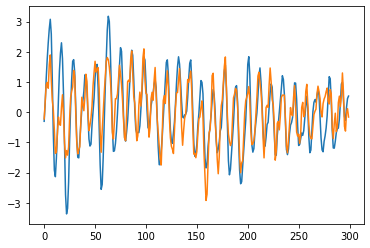

/usr/local/lib/python3.7/dist-packages/torch/_tensor.py:759: ComplexWarning: Casting complex values to real discards the imaginary part
  return self.numpy().astype(dtype, copy=False)
/usr/local/lib/python3.7/dist-packages/torch/_tensor.py:759: ComplexWarning: Casting complex values to real discards the imaginary part
  return self.numpy().astype(dtype, copy=False)


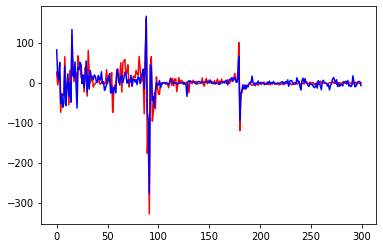

Loss: 0.4285


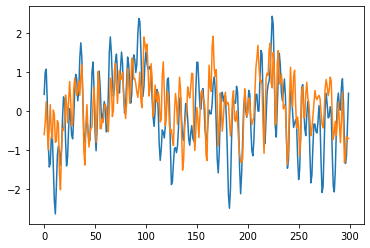

/usr/local/lib/python3.7/dist-packages/torch/_tensor.py:759: ComplexWarning: Casting complex values to real discards the imaginary part
  return self.numpy().astype(dtype, copy=False)
/usr/local/lib/python3.7/dist-packages/torch/_tensor.py:759: ComplexWarning: Casting complex values to real discards the imaginary part
  return self.numpy().astype(dtype, copy=False)


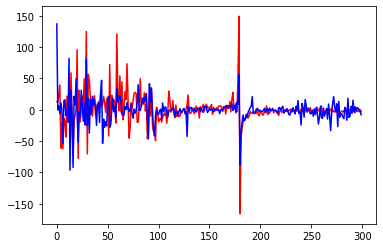

Loss: 0.4298


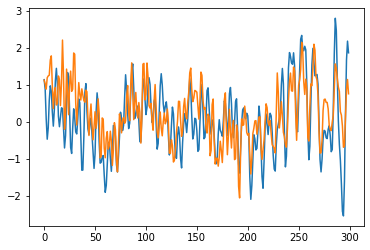

/usr/local/lib/python3.7/dist-packages/torch/_tensor.py:759: ComplexWarning: Casting complex values to real discards the imaginary part
  return self.numpy().astype(dtype, copy=False)
/usr/local/lib/python3.7/dist-packages/torch/_tensor.py:759: ComplexWarning: Casting complex values to real discards the imaginary part
  return self.numpy().astype(dtype, copy=False)


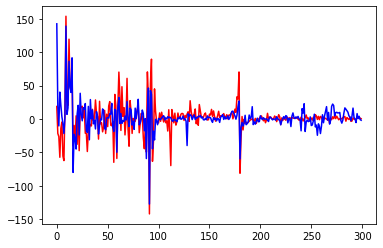

Loss: 0.4260


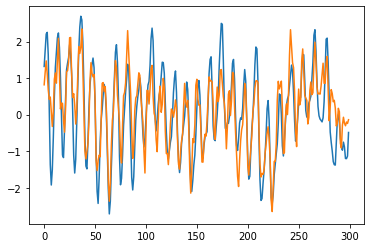

/usr/local/lib/python3.7/dist-packages/torch/_tensor.py:759: ComplexWarning: Casting complex values to real discards the imaginary part
  return self.numpy().astype(dtype, copy=False)
/usr/local/lib/python3.7/dist-packages/torch/_tensor.py:759: ComplexWarning: Casting complex values to real discards the imaginary part
  return self.numpy().astype(dtype, copy=False)


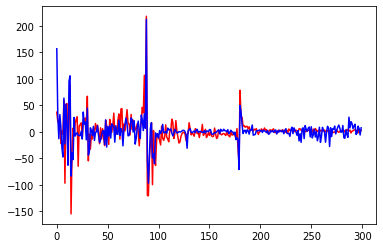

Loss: 0.4316


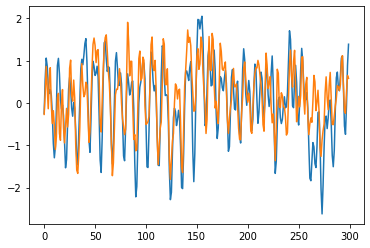

/usr/local/lib/python3.7/dist-packages/torch/_tensor.py:759: ComplexWarning: Casting complex values to real discards the imaginary part
  return self.numpy().astype(dtype, copy=False)
/usr/local/lib/python3.7/dist-packages/torch/_tensor.py:759: ComplexWarning: Casting complex values to real discards the imaginary part
  return self.numpy().astype(dtype, copy=False)


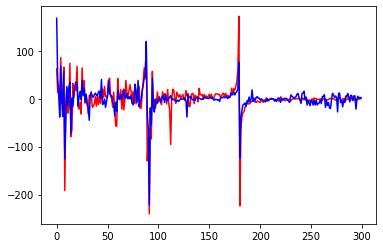

Loss: 0.4147


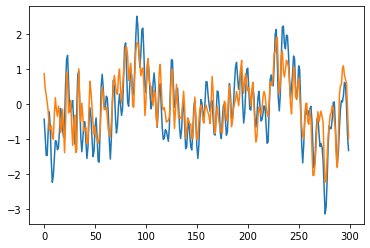

/usr/local/lib/python3.7/dist-packages/torch/_tensor.py:759: ComplexWarning: Casting complex values to real discards the imaginary part
  return self.numpy().astype(dtype, copy=False)
/usr/local/lib/python3.7/dist-packages/torch/_tensor.py:759: ComplexWarning: Casting complex values to real discards the imaginary part
  return self.numpy().astype(dtype, copy=False)


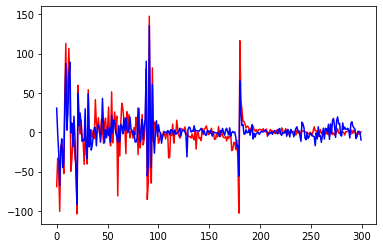

Loss: 0.4155


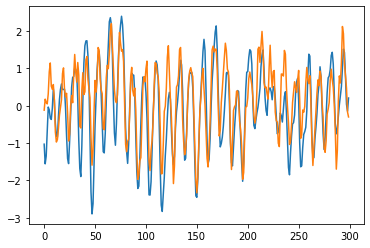

/usr/local/lib/python3.7/dist-packages/torch/_tensor.py:759: ComplexWarning: Casting complex values to real discards the imaginary part
  return self.numpy().astype(dtype, copy=False)
/usr/local/lib/python3.7/dist-packages/torch/_tensor.py:759: ComplexWarning: Casting complex values to real discards the imaginary part
  return self.numpy().astype(dtype, copy=False)


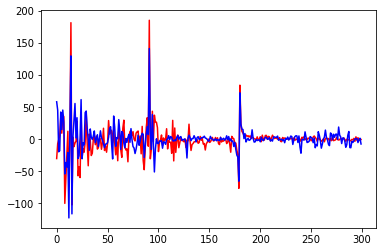

Loss: 0.4157


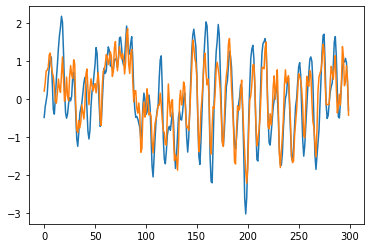

/usr/local/lib/python3.7/dist-packages/torch/_tensor.py:759: ComplexWarning: Casting complex values to real discards the imaginary part
  return self.numpy().astype(dtype, copy=False)
/usr/local/lib/python3.7/dist-packages/torch/_tensor.py:759: ComplexWarning: Casting complex values to real discards the imaginary part
  return self.numpy().astype(dtype, copy=False)


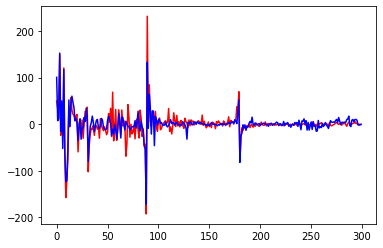

Loss: 0.4362


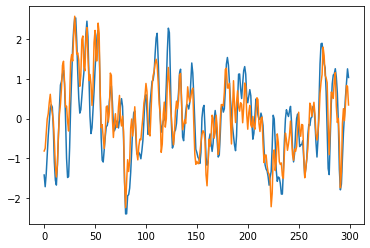

/usr/local/lib/python3.7/dist-packages/torch/_tensor.py:759: ComplexWarning: Casting complex values to real discards the imaginary part
  return self.numpy().astype(dtype, copy=False)
/usr/local/lib/python3.7/dist-packages/torch/_tensor.py:759: ComplexWarning: Casting complex values to real discards the imaginary part
  return self.numpy().astype(dtype, copy=False)


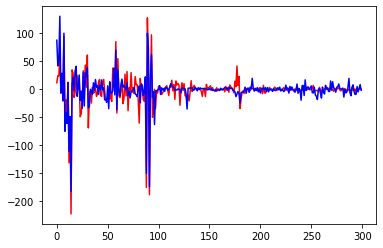

Loss: 0.4292


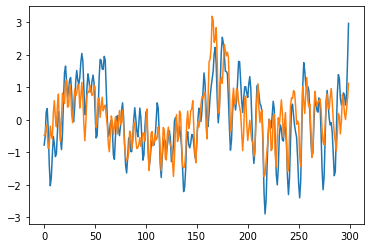

/usr/local/lib/python3.7/dist-packages/torch/_tensor.py:759: ComplexWarning: Casting complex values to real discards the imaginary part
  return self.numpy().astype(dtype, copy=False)
/usr/local/lib/python3.7/dist-packages/torch/_tensor.py:759: ComplexWarning: Casting complex values to real discards the imaginary part
  return self.numpy().astype(dtype, copy=False)


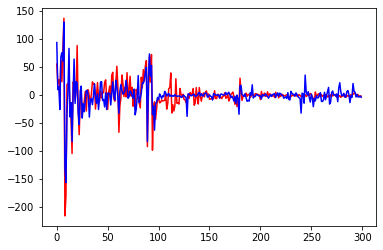

Loss: 0.4263


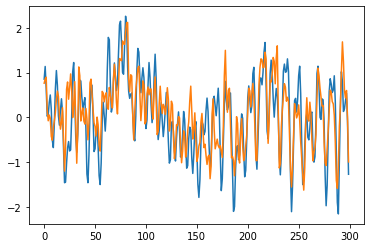

/usr/local/lib/python3.7/dist-packages/torch/_tensor.py:759: ComplexWarning: Casting complex values to real discards the imaginary part
  return self.numpy().astype(dtype, copy=False)
/usr/local/lib/python3.7/dist-packages/torch/_tensor.py:759: ComplexWarning: Casting complex values to real discards the imaginary part
  return self.numpy().astype(dtype, copy=False)


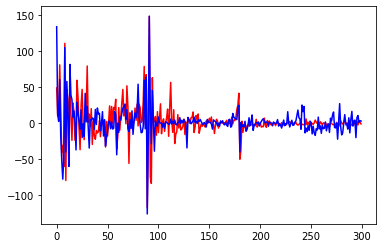

Loss: 0.4321


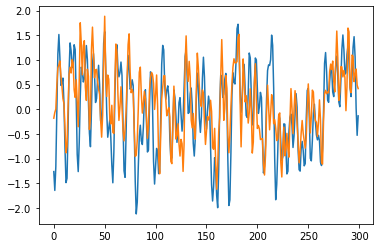

/usr/local/lib/python3.7/dist-packages/torch/_tensor.py:759: ComplexWarning: Casting complex values to real discards the imaginary part
  return self.numpy().astype(dtype, copy=False)
/usr/local/lib/python3.7/dist-packages/torch/_tensor.py:759: ComplexWarning: Casting complex values to real discards the imaginary part
  return self.numpy().astype(dtype, copy=False)


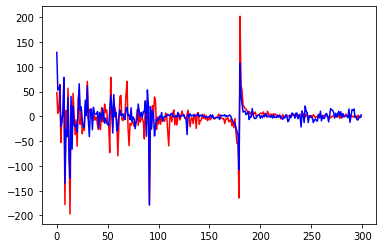

Loss: 0.4281


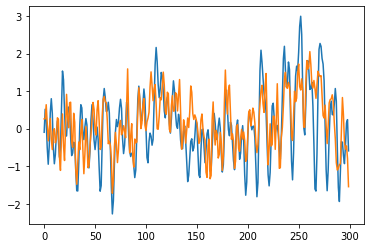

/usr/local/lib/python3.7/dist-packages/torch/_tensor.py:759: ComplexWarning: Casting complex values to real discards the imaginary part
  return self.numpy().astype(dtype, copy=False)
/usr/local/lib/python3.7/dist-packages/torch/_tensor.py:759: ComplexWarning: Casting complex values to real discards the imaginary part
  return self.numpy().astype(dtype, copy=False)


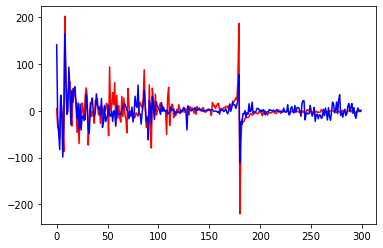

Loss: 0.4270


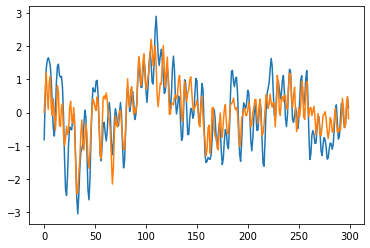

/usr/local/lib/python3.7/dist-packages/torch/_tensor.py:759: ComplexWarning: Casting complex values to real discards the imaginary part
  return self.numpy().astype(dtype, copy=False)
/usr/local/lib/python3.7/dist-packages/torch/_tensor.py:759: ComplexWarning: Casting complex values to real discards the imaginary part
  return self.numpy().astype(dtype, copy=False)


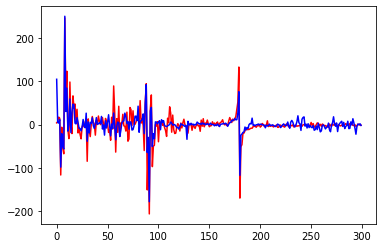

Loss: 0.4273


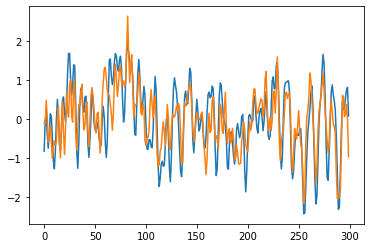

/usr/local/lib/python3.7/dist-packages/torch/_tensor.py:759: ComplexWarning: Casting complex values to real discards the imaginary part
  return self.numpy().astype(dtype, copy=False)
/usr/local/lib/python3.7/dist-packages/torch/_tensor.py:759: ComplexWarning: Casting complex values to real discards the imaginary part
  return self.numpy().astype(dtype, copy=False)


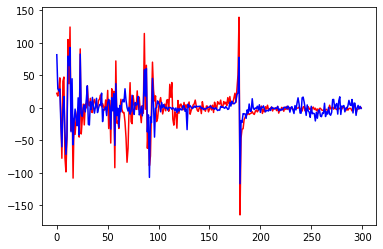

Loss: 0.4203


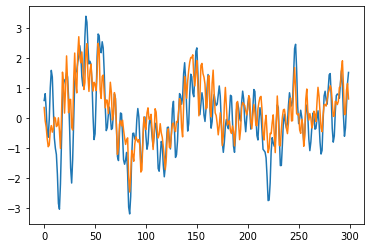

/usr/local/lib/python3.7/dist-packages/torch/_tensor.py:759: ComplexWarning: Casting complex values to real discards the imaginary part
  return self.numpy().astype(dtype, copy=False)
/usr/local/lib/python3.7/dist-packages/torch/_tensor.py:759: ComplexWarning: Casting complex values to real discards the imaginary part
  return self.numpy().astype(dtype, copy=False)


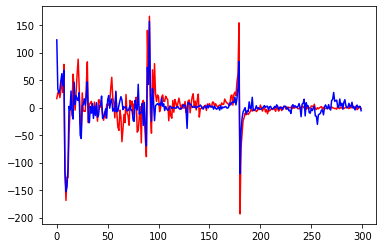

Loss: 0.4181


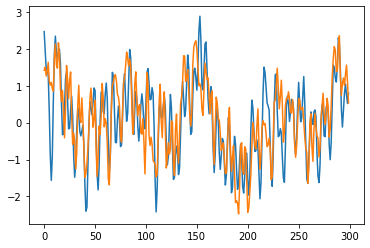

/usr/local/lib/python3.7/dist-packages/torch/_tensor.py:759: ComplexWarning: Casting complex values to real discards the imaginary part
  return self.numpy().astype(dtype, copy=False)
/usr/local/lib/python3.7/dist-packages/torch/_tensor.py:759: ComplexWarning: Casting complex values to real discards the imaginary part
  return self.numpy().astype(dtype, copy=False)


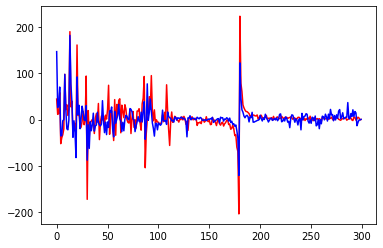

Loss: 0.4147


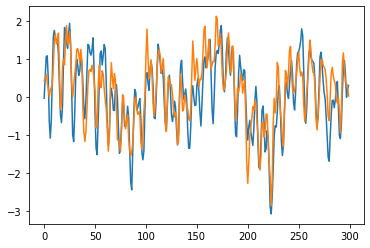

/usr/local/lib/python3.7/dist-packages/torch/_tensor.py:759: ComplexWarning: Casting complex values to real discards the imaginary part
  return self.numpy().astype(dtype, copy=False)
/usr/local/lib/python3.7/dist-packages/torch/_tensor.py:759: ComplexWarning: Casting complex values to real discards the imaginary part
  return self.numpy().astype(dtype, copy=False)


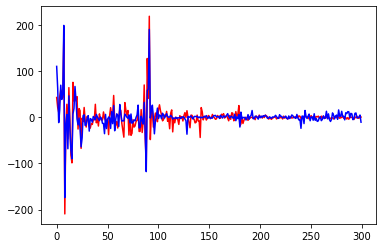

Loss: 0.4248


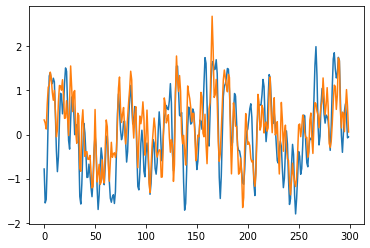

/usr/local/lib/python3.7/dist-packages/torch/_tensor.py:759: ComplexWarning: Casting complex values to real discards the imaginary part
  return self.numpy().astype(dtype, copy=False)
/usr/local/lib/python3.7/dist-packages/torch/_tensor.py:759: ComplexWarning: Casting complex values to real discards the imaginary part
  return self.numpy().astype(dtype, copy=False)


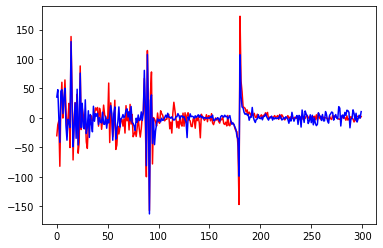

Loss: 0.4228


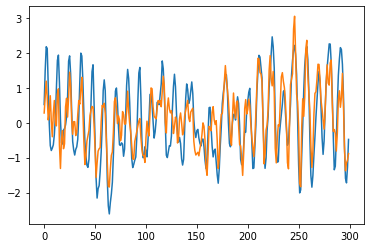

/usr/local/lib/python3.7/dist-packages/torch/_tensor.py:759: ComplexWarning: Casting complex values to real discards the imaginary part
  return self.numpy().astype(dtype, copy=False)
/usr/local/lib/python3.7/dist-packages/torch/_tensor.py:759: ComplexWarning: Casting complex values to real discards the imaginary part
  return self.numpy().astype(dtype, copy=False)


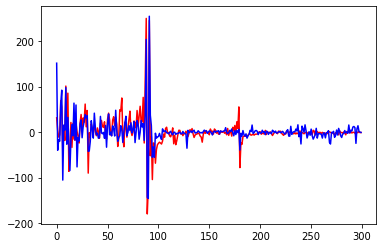

Loss: 0.4323


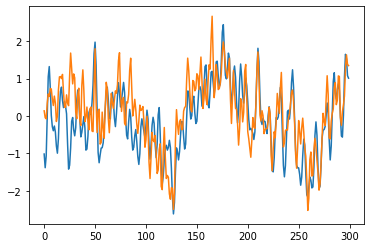

/usr/local/lib/python3.7/dist-packages/torch/_tensor.py:759: ComplexWarning: Casting complex values to real discards the imaginary part
  return self.numpy().astype(dtype, copy=False)
/usr/local/lib/python3.7/dist-packages/torch/_tensor.py:759: ComplexWarning: Casting complex values to real discards the imaginary part
  return self.numpy().astype(dtype, copy=False)


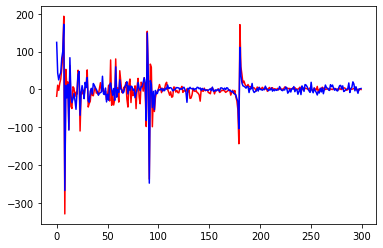

Loss: 0.4260


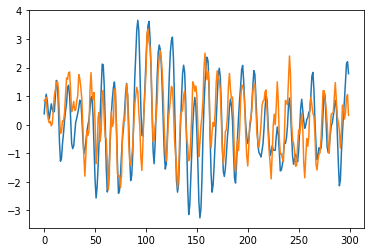

/usr/local/lib/python3.7/dist-packages/torch/_tensor.py:759: ComplexWarning: Casting complex values to real discards the imaginary part
  return self.numpy().astype(dtype, copy=False)
/usr/local/lib/python3.7/dist-packages/torch/_tensor.py:759: ComplexWarning: Casting complex values to real discards the imaginary part
  return self.numpy().astype(dtype, copy=False)


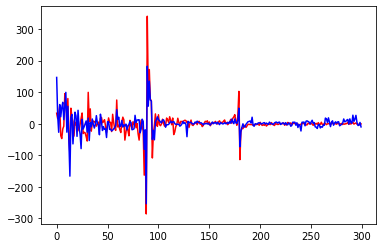

Loss: 0.4188


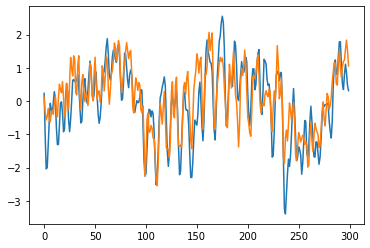

/usr/local/lib/python3.7/dist-packages/torch/_tensor.py:759: ComplexWarning: Casting complex values to real discards the imaginary part
  return self.numpy().astype(dtype, copy=False)
/usr/local/lib/python3.7/dist-packages/torch/_tensor.py:759: ComplexWarning: Casting complex values to real discards the imaginary part
  return self.numpy().astype(dtype, copy=False)


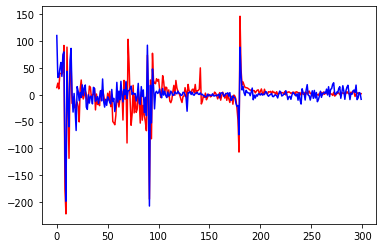

Loss: 0.4091


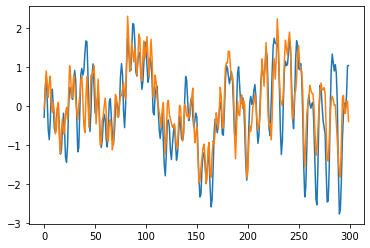

/usr/local/lib/python3.7/dist-packages/torch/_tensor.py:759: ComplexWarning: Casting complex values to real discards the imaginary part
  return self.numpy().astype(dtype, copy=False)
/usr/local/lib/python3.7/dist-packages/torch/_tensor.py:759: ComplexWarning: Casting complex values to real discards the imaginary part
  return self.numpy().astype(dtype, copy=False)


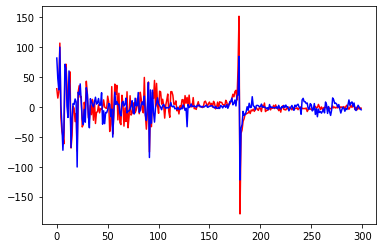

Loss: 0.4285


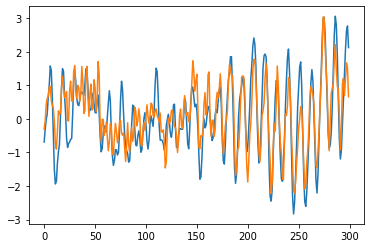

/usr/local/lib/python3.7/dist-packages/torch/_tensor.py:759: ComplexWarning: Casting complex values to real discards the imaginary part
  return self.numpy().astype(dtype, copy=False)
/usr/local/lib/python3.7/dist-packages/torch/_tensor.py:759: ComplexWarning: Casting complex values to real discards the imaginary part
  return self.numpy().astype(dtype, copy=False)


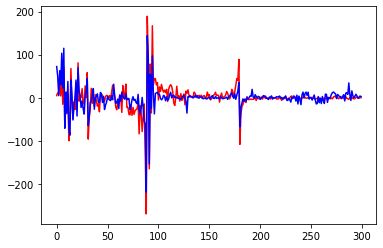

Loss: 0.4222


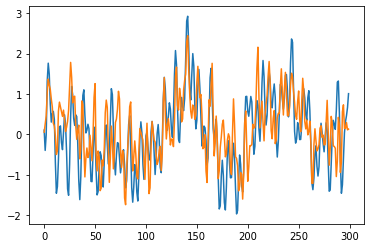

/usr/local/lib/python3.7/dist-packages/torch/_tensor.py:759: ComplexWarning: Casting complex values to real discards the imaginary part
  return self.numpy().astype(dtype, copy=False)
/usr/local/lib/python3.7/dist-packages/torch/_tensor.py:759: ComplexWarning: Casting complex values to real discards the imaginary part
  return self.numpy().astype(dtype, copy=False)


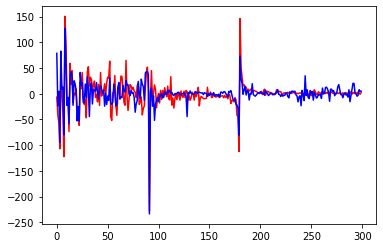

Loss: 0.4166


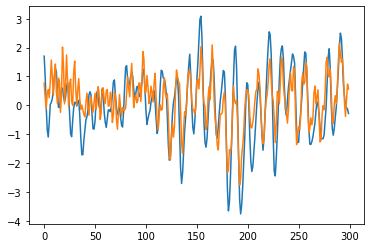

/usr/local/lib/python3.7/dist-packages/torch/_tensor.py:759: ComplexWarning: Casting complex values to real discards the imaginary part
  return self.numpy().astype(dtype, copy=False)
/usr/local/lib/python3.7/dist-packages/torch/_tensor.py:759: ComplexWarning: Casting complex values to real discards the imaginary part
  return self.numpy().astype(dtype, copy=False)


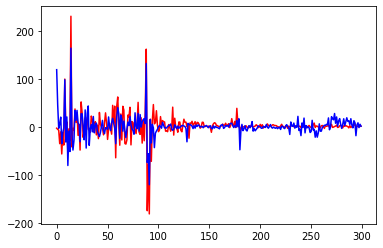

Loss: 0.4151


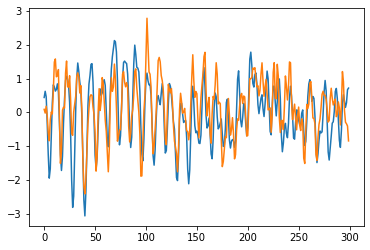

/usr/local/lib/python3.7/dist-packages/torch/_tensor.py:759: ComplexWarning: Casting complex values to real discards the imaginary part
  return self.numpy().astype(dtype, copy=False)
/usr/local/lib/python3.7/dist-packages/torch/_tensor.py:759: ComplexWarning: Casting complex values to real discards the imaginary part
  return self.numpy().astype(dtype, copy=False)


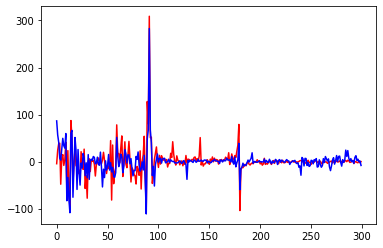

Loss: 0.4185


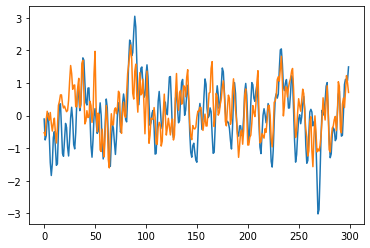

/usr/local/lib/python3.7/dist-packages/torch/_tensor.py:759: ComplexWarning: Casting complex values to real discards the imaginary part
  return self.numpy().astype(dtype, copy=False)
/usr/local/lib/python3.7/dist-packages/torch/_tensor.py:759: ComplexWarning: Casting complex values to real discards the imaginary part
  return self.numpy().astype(dtype, copy=False)


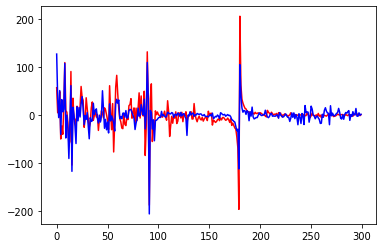

Loss: 0.4259


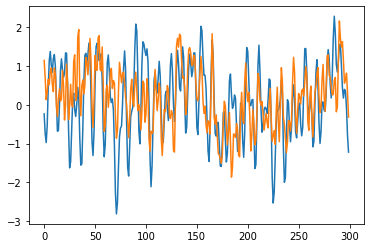

/usr/local/lib/python3.7/dist-packages/torch/_tensor.py:759: ComplexWarning: Casting complex values to real discards the imaginary part
  return self.numpy().astype(dtype, copy=False)
/usr/local/lib/python3.7/dist-packages/torch/_tensor.py:759: ComplexWarning: Casting complex values to real discards the imaginary part
  return self.numpy().astype(dtype, copy=False)


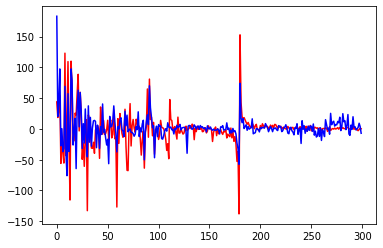

Loss: 0.4215


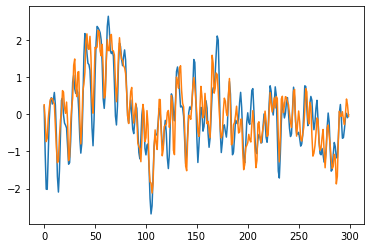

/usr/local/lib/python3.7/dist-packages/torch/_tensor.py:759: ComplexWarning: Casting complex values to real discards the imaginary part
  return self.numpy().astype(dtype, copy=False)
/usr/local/lib/python3.7/dist-packages/torch/_tensor.py:759: ComplexWarning: Casting complex values to real discards the imaginary part
  return self.numpy().astype(dtype, copy=False)


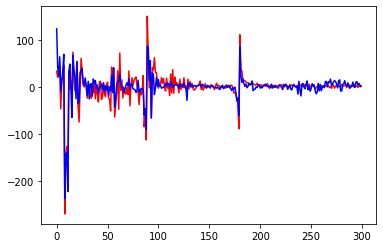

Loss: 0.4298


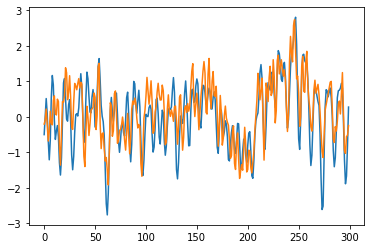

/usr/local/lib/python3.7/dist-packages/torch/_tensor.py:759: ComplexWarning: Casting complex values to real discards the imaginary part
  return self.numpy().astype(dtype, copy=False)
/usr/local/lib/python3.7/dist-packages/torch/_tensor.py:759: ComplexWarning: Casting complex values to real discards the imaginary part
  return self.numpy().astype(dtype, copy=False)


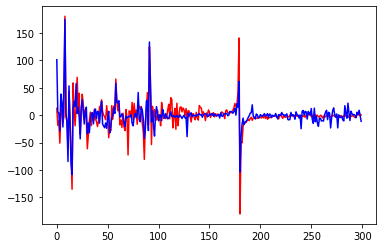

Loss: 0.4106


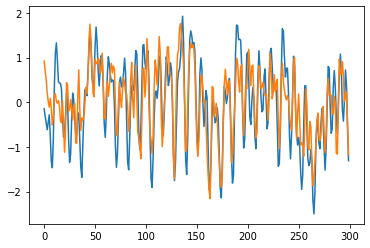

/usr/local/lib/python3.7/dist-packages/torch/_tensor.py:759: ComplexWarning: Casting complex values to real discards the imaginary part
  return self.numpy().astype(dtype, copy=False)
/usr/local/lib/python3.7/dist-packages/torch/_tensor.py:759: ComplexWarning: Casting complex values to real discards the imaginary part
  return self.numpy().astype(dtype, copy=False)


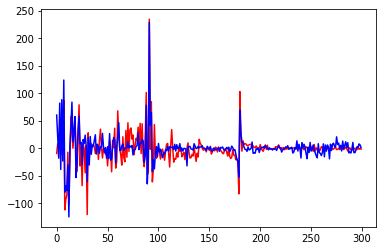

Loss: 0.4303


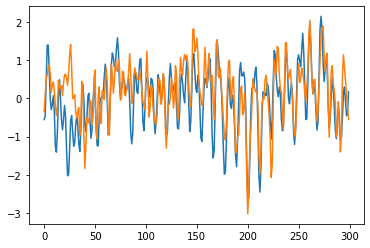

/usr/local/lib/python3.7/dist-packages/torch/_tensor.py:759: ComplexWarning: Casting complex values to real discards the imaginary part
  return self.numpy().astype(dtype, copy=False)
/usr/local/lib/python3.7/dist-packages/torch/_tensor.py:759: ComplexWarning: Casting complex values to real discards the imaginary part
  return self.numpy().astype(dtype, copy=False)


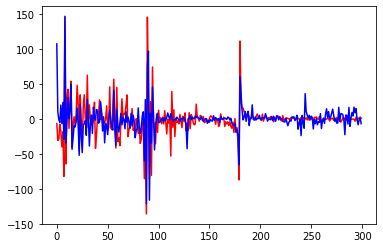

Loss: 0.4230


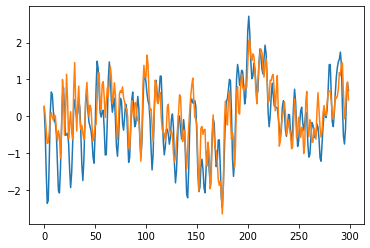

/usr/local/lib/python3.7/dist-packages/torch/_tensor.py:759: ComplexWarning: Casting complex values to real discards the imaginary part
  return self.numpy().astype(dtype, copy=False)
/usr/local/lib/python3.7/dist-packages/torch/_tensor.py:759: ComplexWarning: Casting complex values to real discards the imaginary part
  return self.numpy().astype(dtype, copy=False)


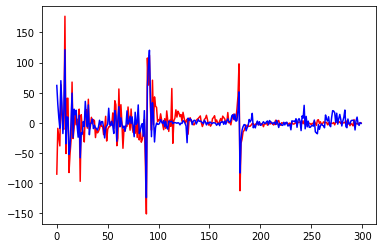

Loss: 0.4333


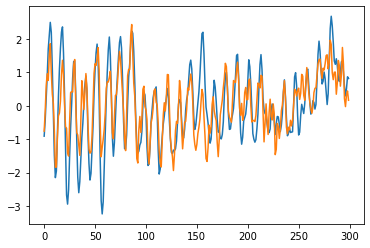

/usr/local/lib/python3.7/dist-packages/torch/_tensor.py:759: ComplexWarning: Casting complex values to real discards the imaginary part
  return self.numpy().astype(dtype, copy=False)
/usr/local/lib/python3.7/dist-packages/torch/_tensor.py:759: ComplexWarning: Casting complex values to real discards the imaginary part
  return self.numpy().astype(dtype, copy=False)


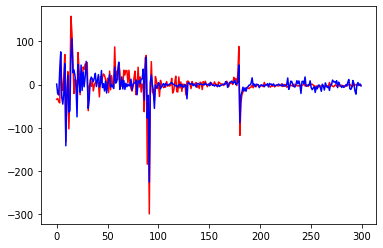

Loss: 0.4320


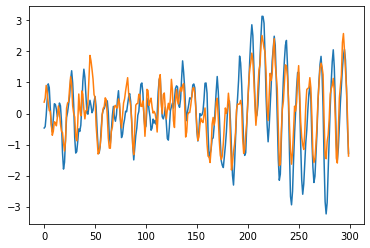

/usr/local/lib/python3.7/dist-packages/torch/_tensor.py:759: ComplexWarning: Casting complex values to real discards the imaginary part
  return self.numpy().astype(dtype, copy=False)
/usr/local/lib/python3.7/dist-packages/torch/_tensor.py:759: ComplexWarning: Casting complex values to real discards the imaginary part
  return self.numpy().astype(dtype, copy=False)


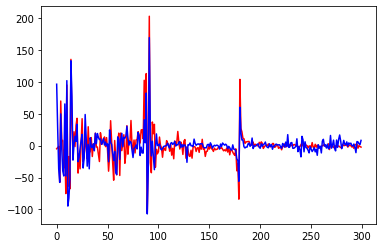

Loss: 0.4328


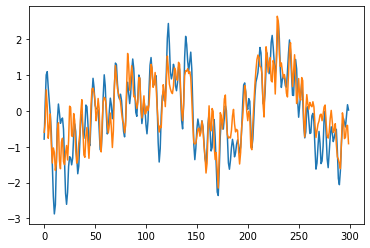

/usr/local/lib/python3.7/dist-packages/torch/_tensor.py:759: ComplexWarning: Casting complex values to real discards the imaginary part
  return self.numpy().astype(dtype, copy=False)
/usr/local/lib/python3.7/dist-packages/torch/_tensor.py:759: ComplexWarning: Casting complex values to real discards the imaginary part
  return self.numpy().astype(dtype, copy=False)


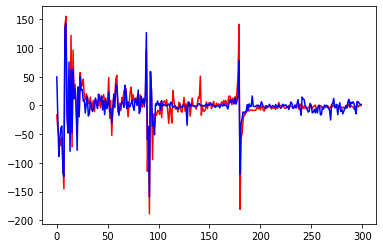

Loss: 0.4126


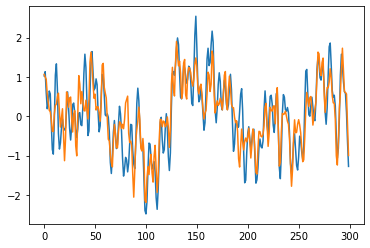

/usr/local/lib/python3.7/dist-packages/torch/_tensor.py:759: ComplexWarning: Casting complex values to real discards the imaginary part
  return self.numpy().astype(dtype, copy=False)
/usr/local/lib/python3.7/dist-packages/torch/_tensor.py:759: ComplexWarning: Casting complex values to real discards the imaginary part
  return self.numpy().astype(dtype, copy=False)


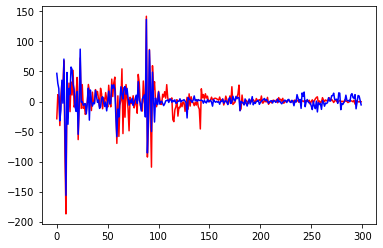

Loss: 0.4232


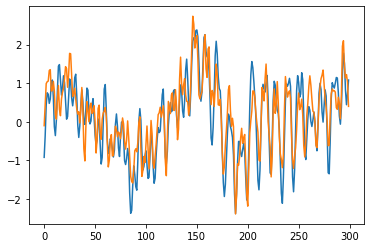

/usr/local/lib/python3.7/dist-packages/torch/_tensor.py:759: ComplexWarning: Casting complex values to real discards the imaginary part
  return self.numpy().astype(dtype, copy=False)
/usr/local/lib/python3.7/dist-packages/torch/_tensor.py:759: ComplexWarning: Casting complex values to real discards the imaginary part
  return self.numpy().astype(dtype, copy=False)


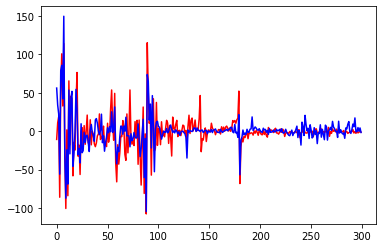

Loss: 0.4182


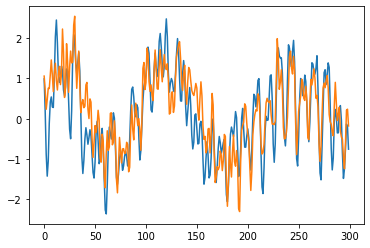

/usr/local/lib/python3.7/dist-packages/torch/_tensor.py:759: ComplexWarning: Casting complex values to real discards the imaginary part
  return self.numpy().astype(dtype, copy=False)
/usr/local/lib/python3.7/dist-packages/torch/_tensor.py:759: ComplexWarning: Casting complex values to real discards the imaginary part
  return self.numpy().astype(dtype, copy=False)


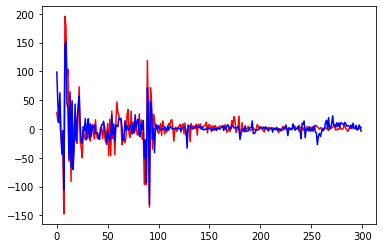

Loss: 0.4175


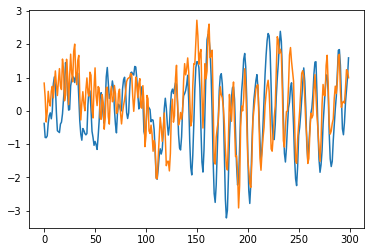

/usr/local/lib/python3.7/dist-packages/torch/_tensor.py:759: ComplexWarning: Casting complex values to real discards the imaginary part
  return self.numpy().astype(dtype, copy=False)
/usr/local/lib/python3.7/dist-packages/torch/_tensor.py:759: ComplexWarning: Casting complex values to real discards the imaginary part
  return self.numpy().astype(dtype, copy=False)


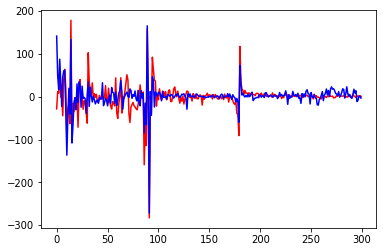

Loss: 0.4185


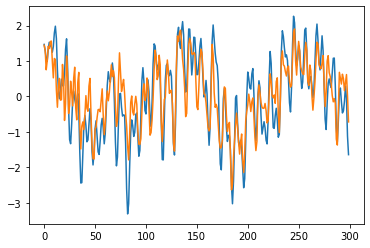

/usr/local/lib/python3.7/dist-packages/torch/_tensor.py:759: ComplexWarning: Casting complex values to real discards the imaginary part
  return self.numpy().astype(dtype, copy=False)
/usr/local/lib/python3.7/dist-packages/torch/_tensor.py:759: ComplexWarning: Casting complex values to real discards the imaginary part
  return self.numpy().astype(dtype, copy=False)


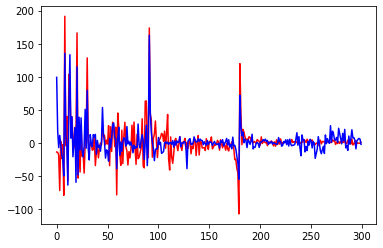

Loss: 0.4300


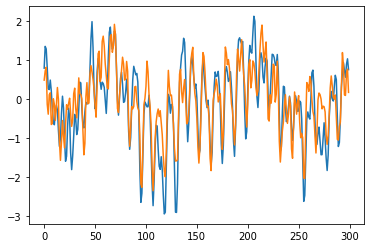

/usr/local/lib/python3.7/dist-packages/torch/_tensor.py:759: ComplexWarning: Casting complex values to real discards the imaginary part
  return self.numpy().astype(dtype, copy=False)
/usr/local/lib/python3.7/dist-packages/torch/_tensor.py:759: ComplexWarning: Casting complex values to real discards the imaginary part
  return self.numpy().astype(dtype, copy=False)


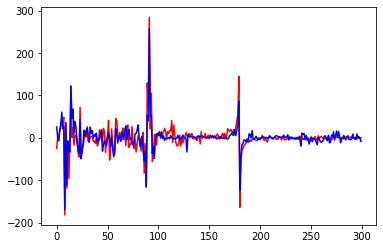

Loss: 0.4175


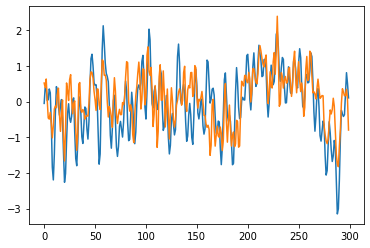

/usr/local/lib/python3.7/dist-packages/torch/_tensor.py:759: ComplexWarning: Casting complex values to real discards the imaginary part
  return self.numpy().astype(dtype, copy=False)
/usr/local/lib/python3.7/dist-packages/torch/_tensor.py:759: ComplexWarning: Casting complex values to real discards the imaginary part
  return self.numpy().astype(dtype, copy=False)


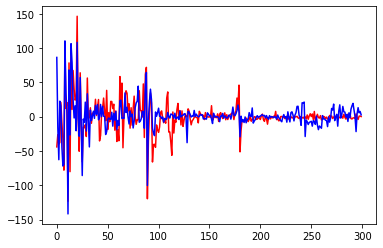

Loss: 0.4241


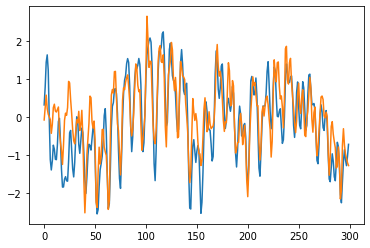

/usr/local/lib/python3.7/dist-packages/torch/_tensor.py:759: ComplexWarning: Casting complex values to real discards the imaginary part
  return self.numpy().astype(dtype, copy=False)
/usr/local/lib/python3.7/dist-packages/torch/_tensor.py:759: ComplexWarning: Casting complex values to real discards the imaginary part
  return self.numpy().astype(dtype, copy=False)


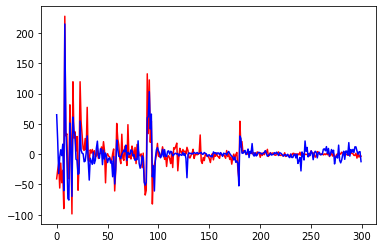

Loss: 0.4231


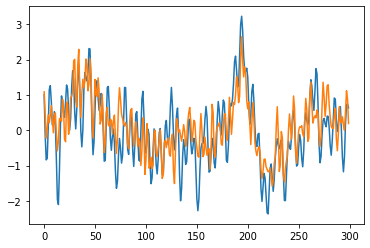

/usr/local/lib/python3.7/dist-packages/torch/_tensor.py:759: ComplexWarning: Casting complex values to real discards the imaginary part
  return self.numpy().astype(dtype, copy=False)
/usr/local/lib/python3.7/dist-packages/torch/_tensor.py:759: ComplexWarning: Casting complex values to real discards the imaginary part
  return self.numpy().astype(dtype, copy=False)


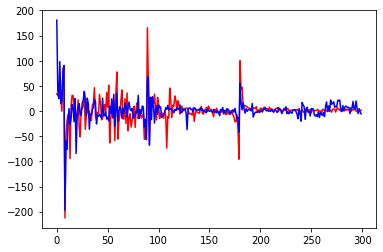

Loss: 0.4266


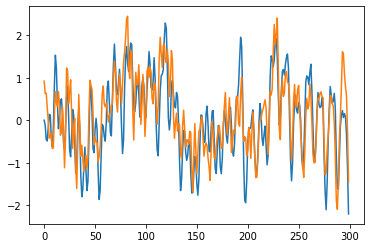

/usr/local/lib/python3.7/dist-packages/torch/_tensor.py:759: ComplexWarning: Casting complex values to real discards the imaginary part
  return self.numpy().astype(dtype, copy=False)
/usr/local/lib/python3.7/dist-packages/torch/_tensor.py:759: ComplexWarning: Casting complex values to real discards the imaginary part
  return self.numpy().astype(dtype, copy=False)


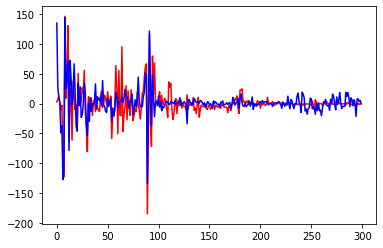

Loss: 0.4310


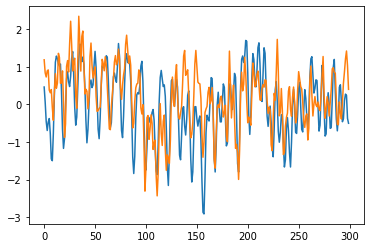

/usr/local/lib/python3.7/dist-packages/torch/_tensor.py:759: ComplexWarning: Casting complex values to real discards the imaginary part
  return self.numpy().astype(dtype, copy=False)
/usr/local/lib/python3.7/dist-packages/torch/_tensor.py:759: ComplexWarning: Casting complex values to real discards the imaginary part
  return self.numpy().astype(dtype, copy=False)


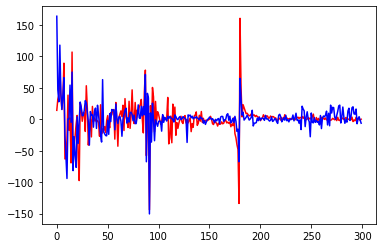

Loss: 0.4256


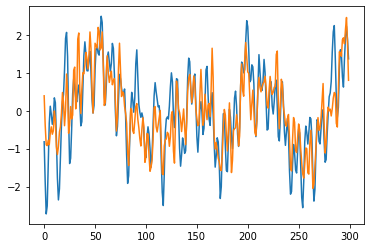

/usr/local/lib/python3.7/dist-packages/torch/_tensor.py:759: ComplexWarning: Casting complex values to real discards the imaginary part
  return self.numpy().astype(dtype, copy=False)
/usr/local/lib/python3.7/dist-packages/torch/_tensor.py:759: ComplexWarning: Casting complex values to real discards the imaginary part
  return self.numpy().astype(dtype, copy=False)


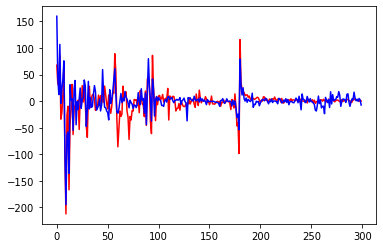

Loss: 0.4162


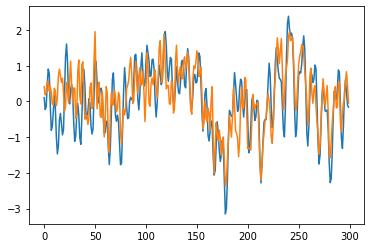

/usr/local/lib/python3.7/dist-packages/torch/_tensor.py:759: ComplexWarning: Casting complex values to real discards the imaginary part
  return self.numpy().astype(dtype, copy=False)
/usr/local/lib/python3.7/dist-packages/torch/_tensor.py:759: ComplexWarning: Casting complex values to real discards the imaginary part
  return self.numpy().astype(dtype, copy=False)


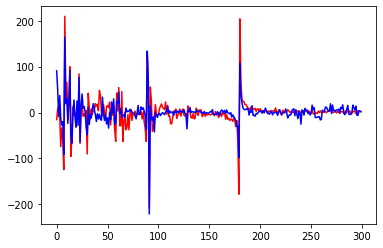

Loss: 0.4311


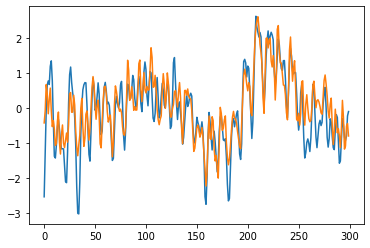

/usr/local/lib/python3.7/dist-packages/torch/_tensor.py:759: ComplexWarning: Casting complex values to real discards the imaginary part
  return self.numpy().astype(dtype, copy=False)
/usr/local/lib/python3.7/dist-packages/torch/_tensor.py:759: ComplexWarning: Casting complex values to real discards the imaginary part
  return self.numpy().astype(dtype, copy=False)


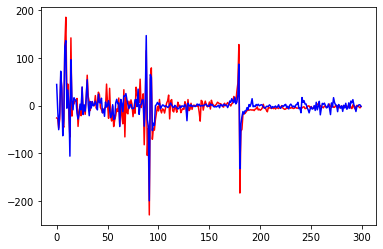

Loss: 0.4043


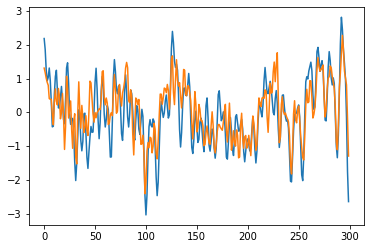

/usr/local/lib/python3.7/dist-packages/torch/_tensor.py:759: ComplexWarning: Casting complex values to real discards the imaginary part
  return self.numpy().astype(dtype, copy=False)
/usr/local/lib/python3.7/dist-packages/torch/_tensor.py:759: ComplexWarning: Casting complex values to real discards the imaginary part
  return self.numpy().astype(dtype, copy=False)


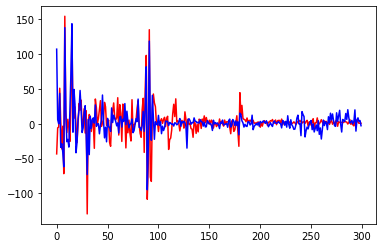

Loss: 0.4249


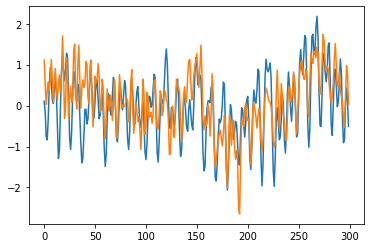

/usr/local/lib/python3.7/dist-packages/torch/_tensor.py:759: ComplexWarning: Casting complex values to real discards the imaginary part
  return self.numpy().astype(dtype, copy=False)
/usr/local/lib/python3.7/dist-packages/torch/_tensor.py:759: ComplexWarning: Casting complex values to real discards the imaginary part
  return self.numpy().astype(dtype, copy=False)


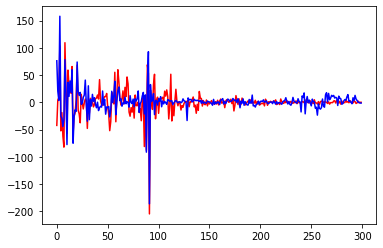

Loss: 0.4156


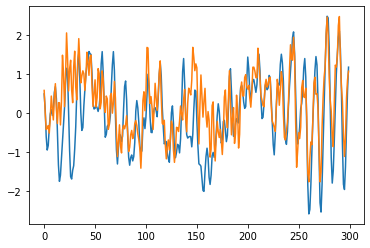

/usr/local/lib/python3.7/dist-packages/torch/_tensor.py:759: ComplexWarning: Casting complex values to real discards the imaginary part
  return self.numpy().astype(dtype, copy=False)
/usr/local/lib/python3.7/dist-packages/torch/_tensor.py:759: ComplexWarning: Casting complex values to real discards the imaginary part
  return self.numpy().astype(dtype, copy=False)


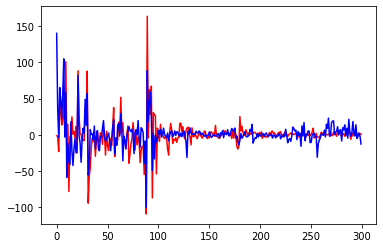

Loss: 0.4271


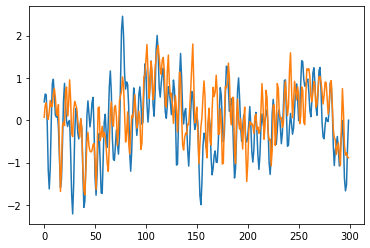

/usr/local/lib/python3.7/dist-packages/torch/_tensor.py:759: ComplexWarning: Casting complex values to real discards the imaginary part
  return self.numpy().astype(dtype, copy=False)
/usr/local/lib/python3.7/dist-packages/torch/_tensor.py:759: ComplexWarning: Casting complex values to real discards the imaginary part
  return self.numpy().astype(dtype, copy=False)


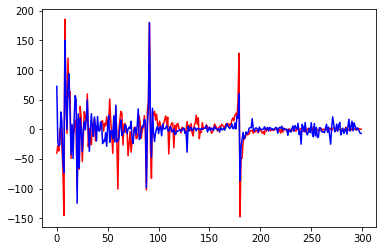

Loss: 0.4333


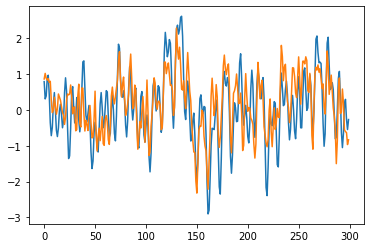

/usr/local/lib/python3.7/dist-packages/torch/_tensor.py:759: ComplexWarning: Casting complex values to real discards the imaginary part
  return self.numpy().astype(dtype, copy=False)
/usr/local/lib/python3.7/dist-packages/torch/_tensor.py:759: ComplexWarning: Casting complex values to real discards the imaginary part
  return self.numpy().astype(dtype, copy=False)


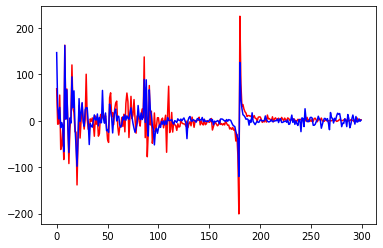

Loss: 0.4330


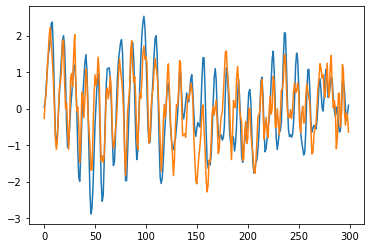

/usr/local/lib/python3.7/dist-packages/torch/_tensor.py:759: ComplexWarning: Casting complex values to real discards the imaginary part
  return self.numpy().astype(dtype, copy=False)
/usr/local/lib/python3.7/dist-packages/torch/_tensor.py:759: ComplexWarning: Casting complex values to real discards the imaginary part
  return self.numpy().astype(dtype, copy=False)


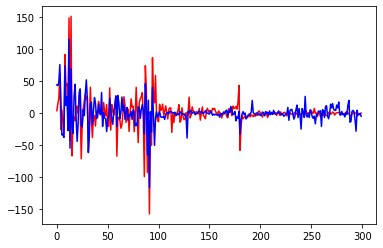

Loss: 0.4369


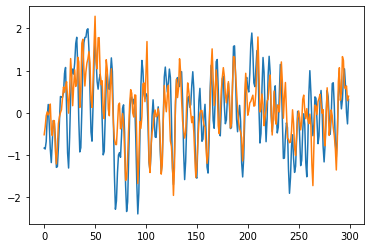

/usr/local/lib/python3.7/dist-packages/torch/_tensor.py:759: ComplexWarning: Casting complex values to real discards the imaginary part
  return self.numpy().astype(dtype, copy=False)
/usr/local/lib/python3.7/dist-packages/torch/_tensor.py:759: ComplexWarning: Casting complex values to real discards the imaginary part
  return self.numpy().astype(dtype, copy=False)


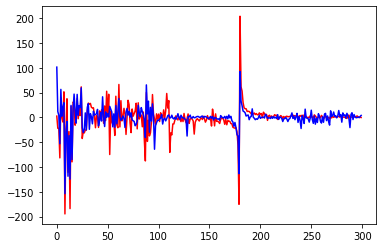

Loss: 0.4137


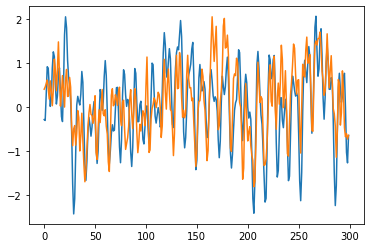

/usr/local/lib/python3.7/dist-packages/torch/_tensor.py:759: ComplexWarning: Casting complex values to real discards the imaginary part
  return self.numpy().astype(dtype, copy=False)
/usr/local/lib/python3.7/dist-packages/torch/_tensor.py:759: ComplexWarning: Casting complex values to real discards the imaginary part
  return self.numpy().astype(dtype, copy=False)


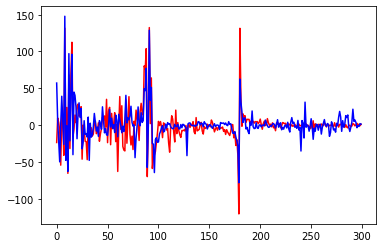

Loss: 0.4265


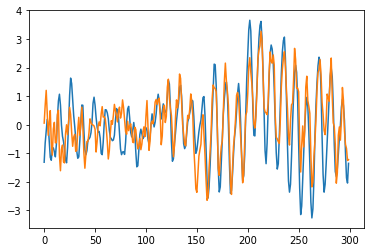

/usr/local/lib/python3.7/dist-packages/torch/_tensor.py:759: ComplexWarning: Casting complex values to real discards the imaginary part
  return self.numpy().astype(dtype, copy=False)
/usr/local/lib/python3.7/dist-packages/torch/_tensor.py:759: ComplexWarning: Casting complex values to real discards the imaginary part
  return self.numpy().astype(dtype, copy=False)


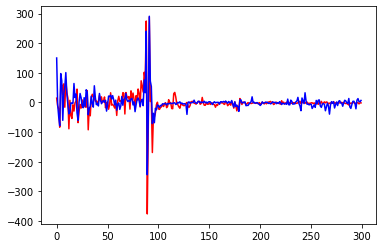

Loss: 0.4194


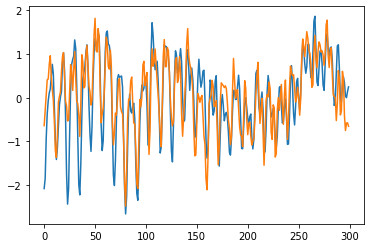

/usr/local/lib/python3.7/dist-packages/torch/_tensor.py:759: ComplexWarning: Casting complex values to real discards the imaginary part
  return self.numpy().astype(dtype, copy=False)
/usr/local/lib/python3.7/dist-packages/torch/_tensor.py:759: ComplexWarning: Casting complex values to real discards the imaginary part
  return self.numpy().astype(dtype, copy=False)


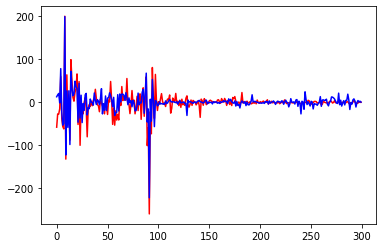

Loss: 0.4343


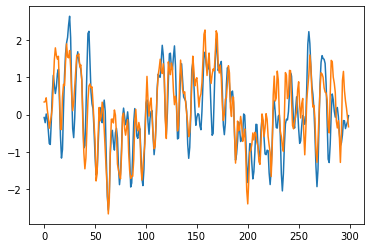

/usr/local/lib/python3.7/dist-packages/torch/_tensor.py:759: ComplexWarning: Casting complex values to real discards the imaginary part
  return self.numpy().astype(dtype, copy=False)
/usr/local/lib/python3.7/dist-packages/torch/_tensor.py:759: ComplexWarning: Casting complex values to real discards the imaginary part
  return self.numpy().astype(dtype, copy=False)


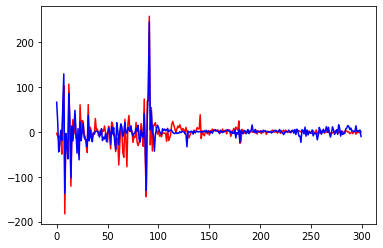

Loss: 0.4224


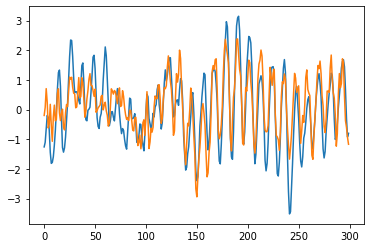

/usr/local/lib/python3.7/dist-packages/torch/_tensor.py:759: ComplexWarning: Casting complex values to real discards the imaginary part
  return self.numpy().astype(dtype, copy=False)
/usr/local/lib/python3.7/dist-packages/torch/_tensor.py:759: ComplexWarning: Casting complex values to real discards the imaginary part
  return self.numpy().astype(dtype, copy=False)


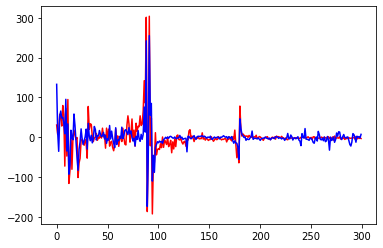

Loss: 0.4283


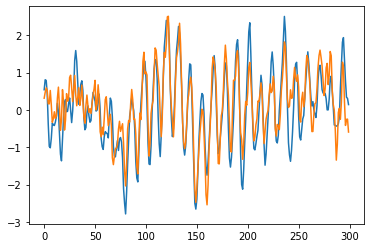

/usr/local/lib/python3.7/dist-packages/torch/_tensor.py:759: ComplexWarning: Casting complex values to real discards the imaginary part
  return self.numpy().astype(dtype, copy=False)
/usr/local/lib/python3.7/dist-packages/torch/_tensor.py:759: ComplexWarning: Casting complex values to real discards the imaginary part
  return self.numpy().astype(dtype, copy=False)


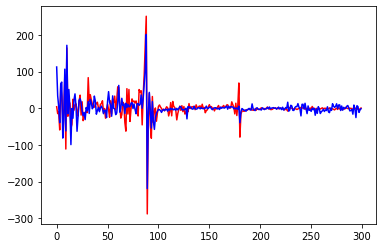

In [ ]:
#TEST DE MODELO
num_epochs=1
#outputs=[]  #anulado para que no se borre el historial de loss

#for epoch in range (num_epochs):
for (f_onda) in dataloader:
        with torch.no_grad():
        
            recon = model(f_onda)
        
            loss=criterion(recon,f_onda)
        
            #optimizer.zero_grad()   # Pone a cero gradientes anteriores
            #loss.backward()         # Recalcula gradientes
            #optimizer.step()        # Aplica optimizador a los parámetros del modelo
        
            print(f'Loss: {loss.item():.4f}')
    

            num_f_onda=0
            long_grafico=300
            plt.plot(np.arange(long_grafico),f_onda[num_f_onda,0,:long_grafico])#plt.plot(np.arange(f_onda.shape[2]),f_onda[num_f_onda,0,:])
            #plt.show()
            recon_np=recon.detach().numpy()[num_f_onda,0,:]
            plt.plot(np.arange(long_grafico),recon_np[:long_grafico])#plt.plot(np.arange(f_onda.shape[2]),recon_np)
            plt.show()
            
            espec_real = torch.fft.rfftn(f_onda[num_f_onda,0,:1025])
            espec_model = torch.fft.rfftn(torch.tensor(recon_np[:1025]))
            plt.plot(np.arange(300),espec_real[:300],'r')
            plt.plot(np.arange(300),espec_model[:300],'b')
            plt.show()

In [ ]:
f_onda[num_f_onda,0,:1025].shape

In [ ]:
recon_np[:long_grafico].shape


In [ ]:
np.arange((1)).shape

In [ ]:
outputs.shape

In [ ]:
datos.shape[2]

In [ ]:
#Saving & Loading Model for Inference
#Save/Load state_dict (Recommended)

#Save:

torch.save(model.state_dict(), "/content/modelo_onda")



In [ ]:
model.state_dict()


OrderedDict([('encoder.0.weight',
              tensor([[[ 0.2571,  0.5494, -0.1821, -0.3585,  0.1655,  0.4503, -0.2227,
                        -0.6924,  0.0761,  0.1438, -0.4725]],
              
                      [[ 0.4301, -0.0711, -0.6661,  0.3402,  0.4890, -0.3803, -0.4498,
                         0.4310,  0.3727, -0.4457, -0.0456]],
              
                      [[-0.4739,  0.1101,  0.6325, -0.2496, -0.6385,  0.4666,  0.5481,
                        -0.6260, -0.2874,  0.3987,  0.1340]],
              
                      [[-0.0293,  0.1008, -0.0232,  0.1323,  0.1948,  0.1375,  0.0656,
                         0.2514, -0.1805,  0.0431, -0.1385]],
              
                      [[-0.2703, -0.4629, -0.0109,  0.4276, -0.1658, -0.4202,  0.2767,
                         0.4716,  0.0457, -0.0329,  0.4300]],
              
                      [[-0.4152, -0.4324,  0.5241,  0.5789, -0.2434, -0.5561,  0.2919,
                         0.4403,  0.0844, -0.2886,  0.0452]

In [ ]:
num_espectro=1

In [ ]:
num_espectro=1100
plt.plot(np.arange(datos.shape[2]),datos[num_espectro,0,:])#plt.plot(np.arange(espec_normal.shape[1]),espec_normal[0])
plt.show()
recon_np=model(datos).detach().numpy()[num_espectro,0,:]
plt.plot(np.arange(datos.shape[2]),recon_np)#plt.plot(np.arange(espec_normal.shape[1]),espec_normal[0])
plt.show()

In [ ]:
recon_np=model(datos).detach().numpy()[num_espectro,0,:]
plt.plot(np.arange(datos.shape[2]),recon_np)#plt.plot(np.arange(espec_normal.shape[1]),espec_normal[0])
plt.show()

In [ ]:
fin

In [ ]:
#Load:

model = Autoencoder()
model.load_state_dict(torch.load("/content/modelo_onda(5)"))
#model.eval()

<All keys matched successfully>

Analysis in the Time Domain
Easy Calculations of Peak, RMS and Crest Factor

The peak will be applied after first finding the absolute value to ensure we don't ignore large negative values.
peak=max(|a|)

Then the RMS is a simple square root of the mean of all the values squared.
rms=
⎷(1n)n∑i=1(ai)2

The crest factor is equal to the peak divided by the RMS. crest=peakrms

In [ ]:
def calc_rms(df):
    rms = df.copy()**2
    rms = rms.mean()**0.5
    return rms

def stat_calc(df):
    df_stats = pd.concat([df.abs().max(),calc_rms(df)],axis=1)
    df_stats.columns = ['Acceleration Peak (g)','Acceleration RMS (g)']
    df_stats['Crest Factor'] = df_stats['Acceleration Peak (g)'] / df_stats['Acceleration RMS (g)']
    df_stats['Standard Deviation (g)'] = df.std()
    df_stats.index.name = 'Data Set'
    return df_stats

df_stats = stat_calc(df)
df_stats.round(3)

In [ ]:
(df_stats['Acceleration RMS (g)']-df_stats['Standard Deviation (g)'])/df_stats['Acceleration RMS (g)']*100


Calculate for Pure Sine Wave


In [ ]:

import numpy as np

def build_sine_wave(fs,length,offset):
    x = np.arange(0, length, 1/fs)
    y = np.sin(x*7*2*np.pi)+offset
    name = str(fs)+' Hz, '+str(offset) + 'g Bias'
    df =  pd.DataFrame({'Time (s)':x,
                       name:y})
    return df.set_index('Time (s)')

df_sine = pd.concat([build_sine_wave(100,2.01,0),
                     build_sine_wave(29,2.01,0),
                     build_sine_wave(29,2.01,1),
                     build_sine_wave(15,2.01,0),
                    ],axis=1)


In [ ]:
import plotly.graph_objects as go

fig = go.Figure()

for c in df_sine.columns:
    df_t = df_sine[c].dropna()
    fig.add_trace(go.Scatter(
        x=df_t.index, 
        y=df_t,
        mode='lines+markers',
        name=c
    ))


fig.update_layout(
    title="Compare 1g 7 Hz Sine Wave Sampled at Different Rates",
    xaxis_title="Time (s)",
    yaxis_title="Acceleration (g)",
    legend_title="Sample Frequency and DC Bias",
)
fig.write_html("/content/untitled",full_html=False,include_plotlyjs='cdn')

fig.show()


Integration to Velocity & Displacement

Now that we did the "easy" calculations let's get the integral of the acceleration data for velocity & displacement. The following functions define how these calculations are done which include doing some filters and applying a windowing function.


In [ ]:
import numpy as np
import scipy.integrate
import scipy.signal
import itertools

def _highpass(array, fs, cutoff=[1.,2000], axis=-1,filt_order=3):
    if cutoff[1]>=fs/2:
        cutoff[1]=fs/2.1
    if cutoff[0]==0:
        return array
    """Apply a highpass filter to an array."""
    array = np.moveaxis(array, axis, -1)

    sos_coeffs = scipy.signal.butter(
        N=filt_order, Wn=cutoff, btype='bandpass', fs=fs, output='sos',
    )

    init_state = scipy.signal.sosfilt_zi(sos_coeffs)
    
    for _ in range(2):
        init_fwd = init_state * array[(Ellipsis, 0) + ((None,)*init_state.ndim)]
        init_fwd = np.moveaxis(init_fwd, array.ndim-1, 0)
        array, _zo = scipy.signal.sosfilt(sos_coeffs, array, axis=-1, zi=init_fwd)
        array = array[..., ::-1]

    return np.moveaxis(array, -1, axis)


def _integrate(array, dt, axis=-1, cutoff=[1.,2000],filt_order=3,alpha=1):
    """Integrate data over an axis."""
    window = scipy.signal.tukey(len(array),alpha=alpha)
    array = np.transpose(window*np.transpose(array))
    
    result = scipy.integrate.cumtrapz(array, dx=dt, initial=0, axis=axis)

    result = _highpass(result, 1/dt, cutoff=cutoff, axis=axis,filt_order=filt_order)
    
    return result


def iter_integrals(array, dt, axis=-1, cutoff=[1.,2000],filt_order=3,alpha=1):
    """Iterate over conditioned integrals of the given original data."""
    array = _highpass(array, fs=1/dt, cutoff=cutoff,axis=axis,filt_order=filt_order)
    while True:
        array.setflags(write=False)  # should NOT mutate shared data
        yield array
        array.setflags(write=True)  # array will be replaced below -> now ok to edit
        array = _integrate(array, dt, axis=axis, cutoff=cutoff,filt_order=filt_order,alpha=alpha)


First Compare Simple Sine Wave

To demonstrate the need for filters & a taper, let's compute the integral with and without applying those first.


In [ ]:
df_sine = build_sine_wave(100,2.41,0)
df_sine.columns = ['Pure']
df_sine['Noise'] = np.random.normal(0, .5, df_sine['Pure'].shape) + df_sine['Pure']
df_sine = df_sine[['Pure','Noise']].dropna()

fig = px.line(df_sine,
             labels={
                     "Time": "Time (s)",
                     "value": "Acceleration (g)",
                     "variable": "Data Set"
                 },
             title="Comparison of 1g 7 Hz Sine Wave With & Without Noise")

fig.write_html("/content/untitled",full_html=False,include_plotlyjs='cdn')
fig.show()

In [ ]:
accel, vel, displ = itertools.islice(iter_integrals(df_sine.to_numpy(), 
                                                    dt=1/100, 
                                                    cutoff=[0,100/3],
                                                    filt_order=3,
                                                    alpha=.0, #apply a taper at start and end, 1 is a hanning, 0 is a rectangular
                                                    axis=0), 3)

def build_df(df,array,scale):
    df[df.columns] = array*scale
    return df

df_accel_sine = build_df(df_sine.copy(),accel,1.0)
df_vel_sine = build_df(df_sine.copy(),vel,386.2205)
df_displ_sine = build_df(df_sine.copy(),displ,386.2205)

In [ ]:
accel, vel, displ = itertools.islice(iter_integrals(df_sine.to_numpy(), 
                                                    dt=1/100, 
                                                    cutoff=[0,100/3],
                                                    filt_order=8,
                                                    alpha=.2, #apply a taper at start and end, 1 is a hanning, 0 is a rectangular
                                                    axis=0), 3)

df_accel_sine2 = build_df(df_sine.copy(),accel,1.0)
df_vel_sine2 = build_df(df_sine.copy(),vel,386.2205)
df_displ_sine2 = build_df(df_sine.copy(),displ,386.2205)

In [ ]:
accel, vel, displ = itertools.islice(iter_integrals(df_sine.to_numpy(), 
                                                    dt=1/100, 
                                                    cutoff=[3,100/3],
                                                    filt_order=8,
                                                    alpha=.2, #apply a taper at start and end, 1 is a hanning, 0 is a rectangular
                                                    axis=0), 3)

df_accel_sine3 = build_df(df_sine.copy(),accel,1.0)
df_vel_sine3 = build_df(df_sine.copy(),vel,386.2205)
df_displ_sine3 = build_df(df_sine.copy(),displ,386.2205)

In [ ]:
df_vel_sine_combo = pd.concat([df_vel_sine,df_vel_sine2,df_vel_sine3],axis=1)
df_vel_sine_combo.columns = ['Pure','Noise','Pure with a Taper','Noise with a Taper','Pure with Filters & Taper','Noise with Filters & Taper']
fig = px.line(df_vel_sine_combo,
             labels={
                     "Time": "Time (s)",
                     "value": "Velocity (in/s)",
                     "variable": "Data Set"
                 },
             title="Comparison of Pure Sine Wave Integrated Velocity Data")
fig.write_html("/content/untitled",full_html=False,include_plotlyjs='cdn')
fig.show()

In [ ]:
df_displ_sine_combo = pd.concat([df_displ_sine,df_displ_sine2,df_displ_sine3],axis=1)
df_displ_sine_combo.columns = ['Pure','Noise','Pure with a Taper','Noise with a Taper','Pure with Filters & Taper','Noise with Filters & Taper']
fig = px.line(df_displ_sine_combo,
             labels={
                     "Time": "Time (s)",
                     "value": "Displacement (in)",
                     "variable": "Data Set"
                 },
             title="Comparison of Pure Sine Wave Integrated Displacement Data")
fig.write_html("/content/untitled",full_html=False,include_plotlyjs='cdn')
fig.show()


Calculate for Bearing Data

Now let's bring these numpy arrays back into a pandas dataframe for both velocity and displacement and add time back in. In this step we'll also apply a scaler to convert units to in/s and in. Our units are currently in g's which equals 9.81 m/s^2. So to convert to inches we need to first get to meters, then to inches: meters/sec2=g∗9.81
inch=meters∗39.3701 inch/sec2=g∗9.81∗39.3701=g∗386.2205

In [ ]:
accel, vel, displ = itertools.islice(iter_integrals(df.to_numpy(), 
                                                    dt=1/fs, 
                                                    cutoff=[5,fs/3],
                                                    filt_order=5,
                                                    alpha=.1, #apply a taper at start and end, 1 is a hanning, 0 is a rectangular
                                                    axis=0), 3)

def build_df(df,array,scale):
    df[df.columns] = array*scale
    return df

df_accel = build_df(df.copy(),accel,1.0)
df_vel = build_df(df.copy(),vel,386.2205)
df_displ = build_df(df.copy(),displ,386.2205)


Plot Integrated Velocity & Displacement

First let's plot the full time range to make sure we don't have any funny business with the start and end of the signal. If there are issues, you'll need to adjust the taper (closer to 1), filter order (lower) and filter frequencies (bring the highpass up and the lowpass down).

The following can be used to plot the full signal, but this may take a few moments.

fig = px.line(df_vel,
             labels={
                     "Time": "Time (s)",
                     "value": "Velocity (in/s)",
                     "variable": "Data Set"
                 },
             title="Comparison of Bearing Velocity Data")
fig.show(renderer='svg',width=900, height=450)

fig = px.line(df_displ,
             labels={
                     "Time": "Time (s)",
                     "value": "Displacement (in)",
                     "variable": "Data Set"
                 },
             title="Comparison of Bearing Displacement Data")
fig.show(renderer='svg',width=900, height=450)

Looks good! Now let's plot a more interactive version in the middle section.


In [ ]:
fig = px.line(df_vel.loc[plot_start:plot_end],
             labels={
                     "Time": "Time (s)",
                     "value": "Velocity (in/s)",
                     "variable": "Data Set"
                 },
             title="Comparison of Bearing Velocity Data")
fig.write_html("/content/bearing-velocity-time-series.html",full_html=False,include_plotlyjs='cdn')

fig.show()

fig = px.line(df_displ.loc[plot_start:plot_end],
             labels={
                     "Time": "Time (s)",
                     "value": "Displacement (in)",
                     "variable": "Data Set"
                 },
             title="Comparison of Bearing Displacement Data")
fig.write_html("/content/bearing-displacement-time-series.html",full_html=False,include_plotlyjs='cdn')

fig.show()

In [ ]:
df_displ_sine_combo = pd.concat([df_displ_sine,df_displ_sine2,df_displ_sine3],axis=1)
df_displ_sine_combo.columns = ['Pure','Noise','Pure with a Taper','Noise with a Taper','Pure with Filters & Taper','Noise with Filters & Taper']
fig = px.line(df_displ_sine_combo,
             labels={
                     "Time": "Time (s)",
                     "value": "Displacement (in)",
                     "variable": "Data Set"
                 },
             title="Comparison of Pure Sine Wave Integrated Displacement Data")
fig.write_html("/content/untitled",full_html=False,include_plotlyjs='cdn')
fig.show()


Calculate for Bearing Data

Now let's bring these numpy arrays back into a pandas dataframe for both velocity and displacement and add time back in. In this step we'll also apply a scaler to convert units to in/s and in. Our units are currently in g's which equals 9.81 m/s^2. So to convert to inches we need to first get to meters, then to inches: meters/sec2=g∗9.81
inch=meters∗39.3701 inch/sec2=g∗9.81∗39.3701=g∗386.2205

In [ ]:
accel, vel, displ = itertools.islice(iter_integrals(df.to_numpy(), 
                                                    dt=1/fs, 
                                                    cutoff=[5,fs/3],
                                                    filt_order=5,
                                                    alpha=.1, #apply a taper at start and end, 1 is a hanning, 0 is a rectangular
                                                    axis=0), 3)

def build_df(df,array,scale):
    df[df.columns] = array*scale
    return df

df_accel = build_df(df.copy(),accel,1.0)
df_vel = build_df(df.copy(),vel,386.2205)
df_displ = build_df(df.copy(),displ,386.2205)


Plot Integrated Velocity & Displacement

First let's plot the full time range to make sure we don't have any funny business with the start and end of the signal. If there are issues, you'll need to adjust the taper (closer to 1), filter order (lower) and filter frequencies (bring the highpass up and the lowpass down).

The following can be used to plot the full signal, but this may take a few moments.

fig = px.line(df_vel,
             labels={
                     "Time": "Time (s)",
                     "value": "Velocity (in/s)",
                     "variable": "Data Set"
                 },
             title="Comparison of Bearing Velocity Data")
fig.show(renderer='svg',width=900, height=450)

fig = px.line(df_displ,
             labels={
                     "Time": "Time (s)",
                     "value": "Displacement (in)",
                     "variable": "Data Set"
                 },
             title="Comparison of Bearing Displacement Data")
fig.show(renderer='svg',width=900, height=450)

Looks good! Now let's plot a more interactive version in the middle section.


In [ ]:
fig = px.line(df_vel.loc[plot_start:plot_end],
             labels={
                     "Time": "Time (s)",
                     "value": "Velocity (in/s)",
                     "variable": "Data Set"
                 },
             title="Comparison of Bearing Velocity Data")
fig.write_html("/content/bearing-velocity-time-series_2.html",full_html=False,include_plotlyjs='cdn')

fig.show()

fig = px.line(df_displ.loc[plot_start:plot_end],
             labels={
                     "Time": "Time (s)",
                     "value": "Displacement (in)",
                     "variable": "Data Set"
                 },
             title="Comparison of Bearing Displacement Data")
fig.write_html("/content/bearing-displacement-time-series_2.html",full_html=False,include_plotlyjs='cdn')

fig.show()


Calculating RMS of Velocity and Displacement

Now that we've calculated the integrated time series of velocity and displacement we can easily calculate the RMS of these. Note that we will focus on the middle 8 seconds to ignore the first and last second because of some weird artifacts that can occur during integration.


In [ ]:
df_stats_2 = pd.concat([calc_rms(df_vel[-4:4]),calc_rms(df_displ[-4:4])],axis=1)
df_stats_2.columns = ['Velocity RMS (in/s)','Displacement RMS (in)']
df_stats_2


Analysis in the Frequency Domain
FFT Function

I don't know why but the scipy FFT function isn't as clean to interface with as the PSD one. So this function will take in a dataframe with the index values being time and return a dataframe with the column values being the real FFT results. I added the ability to return a dataframe of the phase response but... take that with a grain of salt.


In [ ]:
from scipy.fft import fft, fftfreq

def get_fft(df):
    N=len(df)
    fs = len(df)/(df.index[-1]-df.index[0])
    
    x_plot= fftfreq(N, 1/fs)[:N//2]
    
    df_fft = pd.DataFrame()
    df_phase = pd.DataFrame()
    for name in df.columns:
        yf = fft(df[name].values) 
        y_plot= 2.0/N * np.abs(yf[0:N//2])
        
        '''
        phase = np.unwrap(2 * np.angle(yf)) / 2 * 180/np.pi
        df_phase = pd.concat([df_phase,
                            pd.DataFrame({'Frequency (Hz)':x_plot[1:],
                                          name:phase[1:n]}).set_index('Frequency (Hz)')],axis=1)
        '''
        df_fft = pd.concat([df_fft,
                            pd.DataFrame({'Frequency (Hz)':x_plot[1:],
                                          name:y_plot[1:]}).set_index('Frequency (Hz)')],axis=1)
    
    return df_fft

Compare FFT and PSD Results for Simple Sine Wave

In [ ]:
def build_two_sine_wave(fs,length):
    x = np.arange(0, length, 1/fs)
    y = np.sin(x*7*2*np.pi)+np.sin(x*13*2*np.pi)
    name = str(length) + ' s'
    df =  pd.DataFrame({'Time (s)':x,
                       name:y})
    return df.set_index('Time (s)')

In [ ]:
two_sine = build_two_sine_wave(100,10.0)
print(calc_rms(two_sine))
fig = px.line(two_sine,
             labels={
                     "value": "Acceleration (g)",
                     "variable": "Data Set"
                 },
             title="Time History of a Signal with Two Sine Tones (7 & 13 Hz)")

fig.update_layout(showlegend=False)
fig.write_html("/content/time-two-tone-sine-waves.html",full_html=False,include_plotlyjs='cdn')
fig.show()

In [ ]:
fig = px.line(get_fft(build_two_sine_wave(100,10.0)),
             labels={
                     "value": "Acceleration (g)",
                     "variable": "Data Set"
                 },
             title="FFT of a Signal with Two Sine Tones")

fig.update_layout(showlegend=False)
fig.write_html("/content/fft-simple-sine-waves.html",full_html=False,include_plotlyjs='cdn')
fig.show()



In [ ]:
df_sine_fft = pd.concat([
                     get_fft(build_two_sine_wave(100,1.1)),
                     get_fft(build_two_sine_wave(100,5.5)),
                     get_fft(build_two_sine_wave(100,10.5)),
                    ],axis=1)

fig = go.Figure()

for c in df_sine_fft.columns:
    df_t = df_sine_fft[c].dropna()
    fig.add_trace(go.Scatter(
        x=df_t.index, 
        y=df_t,
        #mode='lines+markers',
        name=c
    ))


fig.update_layout(
    title="Compare FFT of a Signal with Two Sine Tones for Different Lengths",
    xaxis_title="Frequency (Hz)",
    yaxis_title="Acceleration (g)",
    legend_title="Recording Length",
)

#fig.update_yaxes(type="log")
#fig.update_yaxes(range=[-3, 0])
fig.write_html("/content/pure-sine-wave-fft-leakage.html",full_html=False,include_plotlyjs='cdn')

fig.show()

In [ ]:
import scipy.signal as signal

def get_psd(df,bin_width):
    fs = len(df)/(df.index[-1]-df.index[0])    
    f, psd = signal.welch(df.to_numpy(), 
                          fs=fs, 
                          nperseg=fs/bin_width,
                          window='hanning',
                          axis=0
                         )

    df_psd = pd.DataFrame(psd,columns=df.columns)
    df_psd.columns
    df_psd['Frequency (Hz)'] = f
    df_psd = df_psd.set_index('Frequency (Hz)')
    return df_psd[1:] #drop the first value because it makes the plots look bad and is effectively 0
    

In [ ]:
df_sine_psd = pd.concat([
                     get_psd(build_two_sine_wave(100,1.1),1),
                     get_psd(build_two_sine_wave(100,5.5),1),
                     get_psd(build_two_sine_wave(100,10.5),1),
                    ],axis=1)

fig = go.Figure()

for c in df_sine_psd.columns:
    df_t = df_sine_psd[c].dropna()
    fig.add_trace(go.Scatter(
        x=df_t.index, 
        y=df_t,
        #mode='lines+markers',
        name=c
    ))


fig.update_layout(
    title="Compare PSD of a Signal with Two Sine Tones for Different Lengths",
    xaxis_title="Frequency (Hz)",
    yaxis_title="Acceleration (g^2/Hz)",
    legend_title="Recording Length",
)

#fig.update_yaxes(type="log")
fig.write_html("/content/pure-sine-wave-psd.html",full_html=False,include_plotlyjs='cdn')

fig.show()

In [ ]:
psd_explained = df_sine_psd.copy()
psd_explained['PSD Value (g^2/Hz)'] = psd_explained['10.5 s']
psd_explained['Cumulative Sum (g^2/Hz)'] = psd_explained['10.5 s'].cumsum()
psd_explained = psd_explained[['PSD Value (g^2/Hz)','Cumulative Sum (g^2/Hz)']].dropna()
psd_explained['Multiply By Bin (g^2)'] = psd_explained['Cumulative Sum (g^2/Hz)']*(psd_explained.index[1]-psd_explained.index[0])
psd_explained['Square Root (g)'] = psd_explained['Multiply By Bin (g^2)']**0.5
psd_explained.index = np.around(psd_explained.index)
psd_explained[5:9].round(3)


Compare FFT and PSD of Bearing Data

In [ ]:
df_fft = pd.concat([
                     get_fft(df[['Normal']][0:.125]),
                     get_fft(df[['Normal']]),
                    ],axis=1)
df_fft.columns=['0.125 Second','10 Seconds']
fig = go.Figure()

for c in df_fft.columns:
    df_t = df_fft[c].dropna()
    fig.add_trace(go.Scatter(
        x=df_t[20:1000].index, 
        y=df_t[20:1000],
        #mode='lines+markers',
        name=c
    ))


fig.update_layout(
    title="Compare FFT of Normal Bearing for Different Lengths",
    xaxis_title="Frequency (Hz)",
    yaxis_title="Acceleration (g)",
    legend_title="Recording Length",
)

fig.update_yaxes(type="log")
fig.update_xaxes(type="log")

fig.write_html("/content/bearing-fft-compare.html",full_html=False,include_plotlyjs='cdn')
fig.show()

In [ ]:
df_psd = pd.concat([
                     get_psd(df[['Normal']][0:.125],16),
                     get_psd(df[['Normal']],16),
                    ],axis=1)
df_psd.columns=['0.125 Second','10 Seconds']
fig = go.Figure()

for c in df_psd.columns:
    df_t = df_psd[c].dropna()
    fig.add_trace(go.Scatter(
        x=df_t[20:1000].index, 
        y=df_t[20:1000],
        #mode='lines+markers',
        name=c
    ))


fig.update_layout(
    title="Compare PSD of Normal Bearing for Different Lengths",
    xaxis_title="Frequency (Hz)",
    yaxis_title="Acceleration (g^2/Hz)",
    legend_title="Recording Length",
)

fig.update_yaxes(type="log")
fig.update_xaxes(type="log")

fig.write_html("/content/bearing-psd-compare.html",full_html=False,include_plotlyjs='cdn')
fig.show()




FFT of Bearing Data

In [ ]:
fig = px.line(get_fft(df),
             labels={
                     "value": "Acceleration (g)",
                     "variable": "Data Set"
                 },
             title="FFT Comparison of Bearing Data")
fig.write_image("/content/")
fig.show(renderer='html',width=900, height=450)


Calculate PSD

The trouble with the FFT is how many points we need to present and that this peak we're finding doesn't seem to have any correlation to the actual conditions. It's too dependent on a bit of chance with where the FFT frequencies lie. A PSD on the other hand normalizes the amplitude to a frequency bin allowing us to widen this bin so we can find the energy density.

In the following function we loop through and create several FFTs defined by length nFFT, then average them together before normalizing to the bin width. I like doing bin widths of 1 Hz which could be accomplished by setting nFFT to the sample rate.


In [ ]:
df_psd = get_psd(df,1)

In [ ]:
fig = px.line(df_psd,
             labels={
                     "value": "Acceleration (g^2/Hz)",
                     "variable": "Data Set"
                 },
              log_x=True,
              log_y=True,
             title="PSD Comparison of Bearing Data")
fig.write_html("/content/bearing-psd-normal-faulty.html",full_html=False,include_plotlyjs='cdn')
fig.show()


Peak from PSD

In [ ]:
df_psd_peaks = pd.concat([df_psd.idxmax(),df_psd.max()],axis=1)
df_psd_peaks.columns = ['Peak Frequency (Hz)','Peak Amplitude (g^2/Hz)']
df_psd_peaks

Show How PSD Relates to RMS

The nice thing about a PSD (in addition to the easy control of the bin width) is that the area directly relates to the RMS level in the time domain. The equation is as follows.
gRMS=√∫PSD(f),df

Let's demonstrate by quickly using the PSD just calculated, integrating, and taking the square root and compare to the values we calculated from the time domain.

In [ ]:
def rms_from_psd(df_psd):
    d_f = df_psd.index[1] - df_psd.index[0]
    df_rms = df_psd.copy()
    df_rms = df_rms*d_f
    df_rms = df_rms.cumsum()
    return(df_rms**0.5)

df_rms = rms_from_psd(df_psd)
rms_compare = pd.concat([df_rms.iloc[-1],df_stats['Acceleration RMS (g)']],axis=1)
rms_compare.columns = ['From PSD','From Time']
rms_compare['Error %'] = (rms_compare['From PSD'] - rms_compare['From Time'])/rms_compare['From Time']*100
rms_compare.round(3)

That is pretty spot on! This also let's us conveniently plot over frequency how the RMS builds.

In [ ]:
fig = px.line(df_rms,
             labels={
                     "value": "Acceleration (g RMS)",
                     "variable": "Data Set"
                 },
              log_x=True,
             title="RMS of PSD of Bearing Data")
fig.write_html("/content/bearing-rms-from-psd.html",full_html=False,include_plotlyjs='cdn')
fig.show()

Calculate Velocity & Displacement from PSD

Another nice thing about the PSD is how easy it is to calculate a velocity and displacement PSD from the acceleration one. We showed you can calculate velocity and displacement in the time domain but remember how finicky the calculation was to how we applied the filters and window? It also was relatively heavy from a computation perspective. If we have to get the PSD anyways, the added computation to get velocity and displacement is trivial. Remember we need to do a unit conversion here too and take special care to remember that we are in g^2.
VelocityPSD=AccelerationPSDw2=AccelerationPSD(2∗f∗π)2DisplacementPSD=AccelerationPSDw4=AccelerationPSD(2∗f∗π)4
PSD

The following will first calculate the PSD for velocity and displacement, and then plot it.

In [ ]:
df_vel_psd = df_psd.copy()
df_disp_psd = df_psd.copy()
for x in df_vel.columns:
    df_vel_psd[x] = df_vel_psd[x]/((df_vel_psd.index*2*np.pi)**2)*(386.2205**2)
    df_disp_psd[x] = df_disp_psd[x]/((df_disp_psd.index*2*np.pi)**4)*(386.2205**2)

In [ ]:
fig = px.line(df_vel_psd,
             labels={
                     "value": "Velocity ((in/s)^2/Hz)",
                     "variable": "Data Set"
                 },
              log_x=True,
              log_y=True,
             title="Velocity PSD Comparison of Bearing Data")
fig.write_html("/content/bearing-velocity-psd.html",full_html=False,include_plotlyjs='cdn')
fig.show()


In [ ]:
fig = px.line(df_disp_psd,
             labels={
                     "value": "Displacement (in^2/Hz)",
                     "variable": "Data Set"
                 },
              log_x=True,
              log_y=True,
             title="Displacement PSD Comparison of Bearing Data")
fig.write_html("/content/bearing-displacement-psd.html",full_html=False,include_plotlyjs='cdn')
fig.show()


RMS from PSD

Now that we have the PSD, calculating the RMS is easy as before. But there is a big caveat... we need to pay attention to the low frequency "stuff" like we did when integrating in the time domain. To illustrate let's first calculate the RMS and compare to what we calculated in the time domain for the entire PSD.


In [ ]:
df_vel_rms = rms_from_psd(df_vel_psd)
df_disp_rms = rms_from_psd(df_disp_psd)

rms_compare = pd.concat([df_vel_rms.iloc[-1],
                         df_stats_2['Velocity RMS (in/s)'],
                         df_disp_rms.iloc[-1],
                         df_stats_2['Displacement RMS (in)']],axis=1)
rms_compare.columns = ['Vel From PSD','Vel From Time','Disp From PSD','Disp From Time']

rms_compare['Vel Error %'] = (rms_compare['Vel From PSD'] - rms_compare['Vel From Time'])/rms_compare['Vel From Time']*100
rms_compare['Disp Error %'] = (rms_compare['Disp From PSD'] - rms_compare['Disp From Time'])/rms_compare['Disp From Time']*100
rms_compare

You can see that the comparison of the two waveforms that had a lot of lower frequency content is WAY off compared to what we did in the time domain. But remember in the time domain we applied a pretty aggressive 5 Hz high pass filter, so let's compare what the RMS value is if we skip all data at or below 5 Hz. This let's us get within +/- 10% with all metrics - not bad!

In [ ]:
df_vel_rms = rms_from_psd(df_vel_psd.iloc[6:])
df_disp_rms = rms_from_psd(df_disp_psd.iloc[6:])

rms_compare = pd.concat([df_vel_rms.iloc[-1],
                         df_stats_2['Velocity RMS (in/s)'],
                         df_disp_rms.iloc[-1],
                         df_stats_2['Displacement RMS (in)']],axis=1)
rms_compare.columns = ['Vel From PSD','Vel From Time','Disp From PSD','Disp From Time']

rms_compare['Vel Error %'] = (rms_compare['Vel From PSD'] - rms_compare['Vel From Time'])/rms_compare['Vel From Time']*100
rms_compare['Disp Error %'] = (rms_compare['Disp From PSD'] - rms_compare['Disp From Time'])/rms_compare['Disp From Time']*100
rms_compare



So which approach is more correct? Well... it depends. When you go the time domain route, it can be a little easier to see your integration is bad when it is "running away" from 0. So you can adjust the filters and repeat. But this can be computationally heavy. When you do it with the PSD you can readily see how the frequency content is impacting your results. But the results aren't necessarily as intuitive to understand. So both approaches are right! It's good to do this check between the two as I've done. One note for those that are paying especially close attention to detail... I used a hanning window with the PSD calcuation after some trial and error to find good agreement with the two different calculation techniques. At first I was using a rectangular window which has terrible frequency leakage that resulted in my integrated results being especially bad.
Build Octave Spaced PSD

You can see from above how easy it is to calculate the RMS based of the PSD. This lets us pick bin sizes that are logarithmically spaced for convenient plotting.
Build Frequency Ranges

So first we'll use a function to build a log spaced octave frequency ranges. The function let's you pass in what spacing you'd like, for example 1/3 octave is often used.


In [ ]:
def build_oct(start,stop,space):
    a = [start]
    while a[-1] < stop:
        a = np.append(a,[a[-1]*(2**space)])
    df = pd.DataFrame(a,columns=['Frequency (Hz)'])
    df['Lower'] = df['Frequency (Hz)']/(2**(space/2))
    df['Upper'] = df['Frequency (Hz)']*(2**(space/2))
    df['Upper'][df['Upper']>stop]=stop
    df['Frequency (Hz)'][df['Frequency (Hz)']>stop]=stop
    df = df.set_index('Frequency (Hz)')
    return df[df['Lower']<stop]

df_oct = build_oct(1,fs/2,1/3)
df_oct

Now that we have the lower and upper ranges defined we can find the RMS within each frequency bin. This function requires that the PSD being passed in is linearly spaced.

In [ ]:
def add_oct_psd(df_psd,df_oct):
    df_oct_psd = df_oct.drop(['Lower','Upper'], axis=1).copy()
    for name in df_psd.columns:
        df_oct_psd[name]=np.nan
    df_oct_rms = df_oct_psd.copy()
    f_step = df_psd.index[1]-df_psd.index[0]
    for i in range(df_oct.shape[0]):
        f_l = df_oct['Lower'].iloc[i]
        f_u = df_oct['Upper'].iloc[i]
        for j in df_psd.columns:
            d_t = df_psd[j][(df_psd.index>=f_l) & (df_psd.index<f_u)]
            d_t = d_t*f_step
            df_oct_psd[j].iloc[i] = d_t.sum()/(f_u-f_l)
            df_oct_rms[j].iloc[i] = d_t.sum()
    return df_oct_psd, df_oct_rms.cumsum()**0.5
            
df_oct_psd,df_oct_rms = add_oct_psd(df_psd,df_oct)


Compare PSD of Linear and Log Spaced Bins

Now we can plot the two PSDs together to see how they look on one plot together which requires Plotly's graph objects and some helper functions. Note that there may be some frequency ranges that have 0s so we will drop those so they don't mess up our pretty plot.


In [ ]:
df_oct_psd = df_oct_psd.loc[~(df_oct_psd==0).all(axis=1)] #drop all rows that have a 0

import plotly.graph_objects as go

fig = go.Figure()

def add_trace(df,col,name):
    fig.add_trace(go.Scatter(
        x=df.index, 
        y=df[col],
        name=name+" - "+col
    ))

def add_full_df(df,name):
    for x in df.columns:
        add_trace(df,x,name)
        
add_full_df(df_psd,'Linear Bins')
add_full_df(df_oct_psd,'Logarithmic Bins')

fig.update_yaxes(type="log")
fig.update_xaxes(type="log")

fig.update_layout(
    title="Compare PSDs",
    xaxis_title="Frequency (Hz)",
    yaxis_title="Acceleration (g^2/Hz)",
    legend_title="Legend Title",
)
fig.write_html("/content/log-psd.html",full_html=False,include_plotlyjs='cdn')

fig.show()

In [ ]:
fig = px.line(df_oct_psd,
             labels={
                     "value": "Acceleration (g^2/Hz)",
                     "variable": "Data Set"
                 },
              log_x=True,
              log_y=True,
             title="1/3 Octave PSD Comparison of Bearing Data")
fig.write_html("/content/1-3-octave-psd-bearing.html",full_html=False,include_plotlyjs='cdn')
fig.show()


Plot Cumulative RMS of Linear & Log Spaced PSDs

Remember how spot on our RMS calculation was from the linear spaced PSD, let's see how it looks with the log spaced.


In [ ]:
fig = go.Figure()

add_full_df(df_rms,'Linear Bins')
add_full_df(df_oct_rms,'Logarithmic Bins')

fig.update_xaxes(type="log")

fig.update_layout(
    title="Compare Cumulative RMS from PSDs",
    xaxis_title="Frequency (Hz)",
    yaxis_title="Acceleration RMS (g)",
    legend_title="Legend Title",
)
fig.show()

In [ ]:
fig = px.line(df_oct_rms,
             labels={
                     "value": "Acceleration RMS (g)",
                     "variable": "Data Set"
                 },
              log_x=True,
             title="1/3 Octave Cumulative RMS from PSD")
fig.write_html("/content/1-3-octave-rms-from-psd-bearing.html",full_html=False,include_plotlyjs='cdn')
fig.show()


Find RMS within Arbitrary Range

Now that we have verified the cumulative RMS is spot on, let's build a dataframe that has values for the RMS within each range and add appropriate labels to pull the upper and lower frequency range into the label.


In [ ]:
df_rms_ranges = pd.DataFrame({'Lower':[1,65,300],
                             'Upper':[65,300,6000]})

df_rms_ranges['Frequency (Hz)'] = (df_rms_ranges['Lower']+df_rms_ranges['Upper'])/2
df_rms_ranges = df_rms_ranges.set_index('Frequency (Hz)')
df_rms_ranges

In [ ]:
df_arb_psd,df_arb_rms = add_oct_psd(df_psd,df_rms_ranges)

In [ ]:
fig = go.Figure()

add_full_df(df_psd,'Linear Bins')
add_full_df(df_arb_psd,'Arbitrary Bins')

fig.update_yaxes(type="log")
fig.update_xaxes(type="log")

fig.update_layout(
    title="Compare PSDs",
    xaxis_title="Frequency (Hz)",
    yaxis_title="Acceleration (g^2/Hz)",
    legend_title="Legend Title",
)
fig.show()



In [ ]:
fig = go.Figure()

add_full_df(df_rms,'Linear Bins')
add_full_df(df_arb_rms,'Arbitrary Bins')

fig.update_xaxes(type="log")

fig.update_layout(
    title="Compare Cumulative RMS from PSDs",
    xaxis_title="Frequency (Hz)",
    yaxis_title="Acceleration RMS (g)",
    legend_title="Legend Title",
)
fig.show()

In [ ]:
df_arb_rms_bins = df_arb_rms.diff()
df_arb_rms_bins.iloc[0] = df_arb_rms.iloc[0]

df_arb_rms_bins['Frequency Range (Hz)'] = ' '
for i in range(df_arb_rms_bins.shape[0]):
    ind=df_arb_rms.index[i]
    df_arb_rms_bins.loc[df_arb_rms_bins.index==ind,'Frequency Range (Hz)'] = str(df_rms_ranges['Lower'].iloc[i].round(1)) + ' to ' + str(df_rms_ranges['Upper'].iloc[i].round(1))

df_arb_rms_bins = df_arb_rms_bins.set_index('Frequency Range (Hz)')
df_arb_rms_bins

In [ ]:
fig = px.bar(df_arb_rms_bins,
             labels={
                     "value": "Acceleration RMS (g)",
                     "variable": "Data Set"
                 },
             barmode='group',
             title="Comparison of RMS per Frequency Bin of Bearing Data")
fig.write_html("/content/grms-vs-frequency.html",full_html=False,include_plotlyjs='cdn')
fig.show()

Reorganize the dataframe so it will be easy to combine with other stats later.

In [ ]:
df_arb_rms_bins = df_arb_rms_bins.T
df_arb_rms_bins.columns = ['RMS (g) from ' + str(col) for col in df_arb_rms_bins.columns]
df_arb_rms_bins


Calculate Pseudo Velocity Shock Spectrum & Peak

In [ ]:
from collections import namedtuple
import warnings

import numpy as np
import scipy.signal


def rel_displ(accel, omega, dt=1, damp=0, axis=-1):
    """Calculate the relative velocity for a SDOF system."""
    # Generate the transfer function
    #   H(s) = L{z(t)}(s) / L{y"(t)}(s) = (1/s²)(Z(s)/Y(s))
    # for the PDE
    #   z" + (2ζω)z' + (ω^2)z = -y"
    with warnings.catch_warnings():
        warnings.simplefilter('ignore', scipy.signal.BadCoefficients)

        tf = scipy.signal.TransferFunction(
            [-1],
            [1, 2*damp*omega, omega**2],
        ).to_discrete(dt=dt)

    return scipy.signal.lfilter(tf.num, tf.den, accel, axis=axis)


def pseudo_velocity(accel, freqs, dt=1, damp=0, two_sided=False, axis=-1):
    """The pseudo velocity of an acceleration signal."""
    freqs = np.asarray(freqs)
    omega = 2*np.pi*freqs

    accel = np.moveaxis(accel, axis, -1)

    results = np.empty((2,) + freqs.shape + accel.shape[:-1], dtype=np.float)

    for i_nd in np.ndindex(freqs.shape):
        rd = rel_displ(accel, omega[i_nd], dt, damp=damp)

        results[(0,)+i_nd] = -omega[i_nd]*rd.min(axis=-1)
        results[(1,)+i_nd] = omega[i_nd]*rd.max(axis=-1)

    # Move any frequency axes in place of the specified acceleration axis
    results = np.moveaxis(
        results,
        np.arange(1, omega.ndim+1),
        np.arange(1, omega.ndim+1) + (axis % accel.ndim),
    )

    if not two_sided:
        return np.maximum(results[0], results[1])

    return namedtuple('PseudoVelocityResults', 'neg pos')(*results)

In [ ]:
#freqs = np.linspace(1,fs/2,num=int(fs/2)) #linear spaced 1 Hz bins, but runs MUCH faster if you use log spaced
def build_freqs(start,stop,space):
    a = [start]
    while a[-1] < stop:
        a.append(a[-1]*(2**space))
    return a

freqs = build_freqs(1,fs/2,1/24)

pvss = pseudo_velocity(df.to_numpy(), freqs, dt=1/fs, damp=0.05, two_sided=False, axis=0)*386.2205

df_pvss = pd.DataFrame(pvss,columns=df.columns)
df_pvss['Frequency (Hz)'] = freqs
df_pvss = df_pvss.set_index('Frequency (Hz)')
df_pvss

303 rows × 4 columns

In [ ]:
fig = px.line(df_pvss,
             labels={
                     "value": "Peak Pseudo Velocity (in/s)",
                     "variable": "Data Set"
                 },
              log_x=True,
              log_y=True,
             title="PVSS Comparison of Bearing Data")
fig.write_html("/content/bearing-pvss.html",full_html=False,include_plotlyjs='cdn')

fig.show()

There is some funny business going on with lower frequencies that aren't going to be very relevant to us. So let's ignore everything under 20 Hz, and then find the peak pseudo velocity and corresponding frequency.

In [ ]:
df_pvss_stats = pd.concat([df_pvss[20:].max(),df_pvss[20:].idxmax()],axis=1)
df_pvss_stats.columns=['Peak PV (in/s)','Peak PV (Hz)']
df_pvss_stats


Compare Stats
Table

First we can do a simple table to compare by combining it all together and transposing it, then printing the dataframe.


In [ ]:
df_stats_final = pd.concat([df_stats,df_stats_2,df_psd_peaks['Peak Frequency (Hz)'],df_arb_rms_bins,df_pvss_stats],axis=1)

df_stats_final = df_stats_final.T #transpose
df_stats_final = df_stats_final.iloc[:, ::-1] #Reverse order of columns
df_stats_final


Plot Each Variable with a Drop Down

Now we can expose a way to have a bar chart of each metric, but let you chose in a dropdown which metric to display. This is from a nice person on stack overflow - amazing.


In [ ]:
df_plots = df_stats_final.T

fig = px.bar(df_plots, y=df_plots.columns[0])

updatemenu = []
buttons = []

# button with one option for each dataframe
for col in df_plots.columns:
    buttons.append(dict(method='restyle',
                        label=col,
                        visible=True,
                        args=[{'y':[df_plots[col]],
                               'x':[df_plots.index],
                               'type':'bar'}, [0]],
                        )
                  )

# some adjustments to the updatemenus
updatemenu = []
your_menu = dict()
updatemenu.append(your_menu)

updatemenu[0]['buttons'] = buttons
updatemenu[0]['direction'] = 'down'
updatemenu[0]['showactive'] = True

# add dropdown menus to the figure
fig.update_layout(showlegend=False, updatemenus=updatemenu)
fig.update_yaxes(title_text='')
fig.update_xaxes(title_text='Data Set')

fig.show()


Plot All Stats in One Dashboard

The great thing about plotly and dataframes is how easy it is to generate SWEET plots. In this final example, I am going to generate a simple dashboard to show each plot separately in one view. It first requires us to restructure the dataframe to have just three columns: value, stat, dataset. Then generating the facet plot is pretty easy!


In [ ]:
values = []
data_set = []
stat = []
x = 0
for i in range(df_stats_final.shape[0]):
    for col in df_stats_final.columns:
        values.append(df_stats_final[col].iloc[i])
        data_set.append(col)
        stat.append(df_stats_final.index[i])

df_stats_collapsed = pd.DataFrame(values,columns=['Values'])
df_stats_collapsed['Stat'] = stat
df_stats_collapsed['Data Set'] = data_set
df_stats_collapsed

In [ ]:
fig = px.bar(df_stats_collapsed, x="Data Set", y="Values", facet_col="Stat",facet_col_wrap = 4)
fig.update_yaxes(matches=None)
fig.update_yaxes(visible=False)
fig.write_html("/content/bearing-dashboard.html",full_html=False,include_plotlyjs='cdn')

fig.show()

In [ ]:
"""
Appendix
Installation

You can get most of what you need with the free anaconda edition that will include some of the core libraries like pandas, numpy and scipy. To download visit the anaconda individual edition page.

There are several different interfaces for writing your code but this was all generated in Jupyter which lends itself well to documenting a test/analysis report. It also allows for easy export to HTML for sharing interactive reports.
Modules

There will be some libraries that aren't included that you may need. To install type the following in Jupyter and replace plotly (which you'll need) with whatever library name you're hoping to install.

!pip install plotly

Ploting in Jupyter
Matplotlib

Matplotlib is the default plotting library and built into pandas. You can simply add .plot() to the end of your dataframe to plot it. These won't be interactive though and the default size is too small. So the following shows how to make the plot bigger if you'd like to use this.

import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (20,10)
df_accel.plot()
df_vel.plot()
df_displ.plot()

Plotly (My Favorite)
Save Plot to Chart Studio

You will need to replace the api_key with your own account information. I didn't end up going this route but wanted to show how this can be done.

import chart_studio
chart_studio.tools.set_credentials_file(username='your_user_name', api_key='your_api_key')
import chart_studio.plotly as py
py.plot(fig, filename = 'your_filename', auto_open=True)

Save Plot as HTML and PNG

fig.write_html("/content/bearing-time-series.html",full_html=False,include_plotlyjs='cdn')
fig.write_image("/content/bearing-time-series.png")
fig.write_image("/content/bearing-time-series.svg")

Manipulating .MAT Files from Case Western into Pandas CSV

The data is saved as .mat files so we need to load them and convert to a handy DataFrame. This is a bit convoluted based on how they named the variables within each .mat file. We are going to only be getting the "Drive End" accelerometer data which has "DE" in the variable name.

import scipy.io
import pandas as pd
import numpy as np
def load_mat(name,var):
    dic = scipy.io.loadmat("/content/Desktop/enDAQ/Marketing-Content/What-to-Monitor/"+name+".mat")
    con_list = [[element for element in upperElement] for upperElement in dic[var]]
    df = pd.DataFrame(con_list)
    return df

Normal = load_mat('Normal','X098_DE_time')
Fault_007 = load_mat('Fault_007','X279_DE_time')
Fault_014 = load_mat('Fault_014','X275_DE_time')
Fault_021 = load_mat('Fault_021','X271_DE_time')

#Merge into 1 Dataframe
df = pd.concat([Fault_021,Fault_014,Fault_007,Normal],axis=1)

#Truncate to first 120000 points
df=df.loc[:119999]

# Create Column Names
df.columns = ['Fault_021','Fault_014','Fault_007','Normal']

# Add Column of Time
df['Time'] = np.linspace(0,120000,num=120000)/12000
df = df.set_index('Time')
print(df.head())
df.reset_index().to_csv(path_or_buf="/content/Desktop/enDAQ/Marketing-Content/What-to-Monitor/Bearing_Data.csv",index=False)

